![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "DF-Brazil"
infer_parameters_from_data = True
results_suffix = ".df-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,110,2,1423,30,3015268.0,NaN,21345,NaN
2020-05-01,123,1,1546,31,3015268.0,NaN,23190,NaN
2020-05-02,59,1,1605,32,3015268.0,NaN,24075,NaN
2020-05-03,115,1,1720,33,3015268.0,NaN,25800,NaN
2020-05-04,0,0,1720,33,3015268.0,NaN,25800,NaN


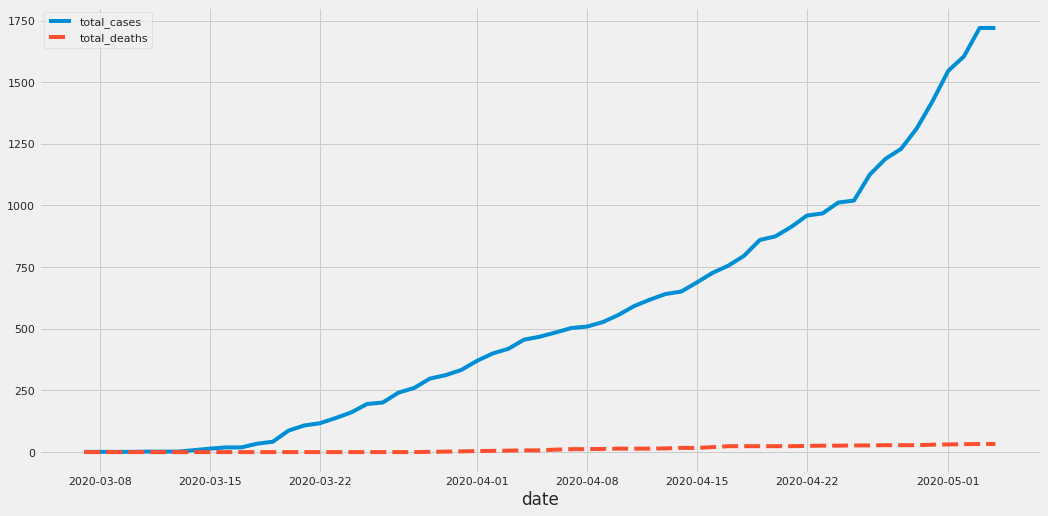

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

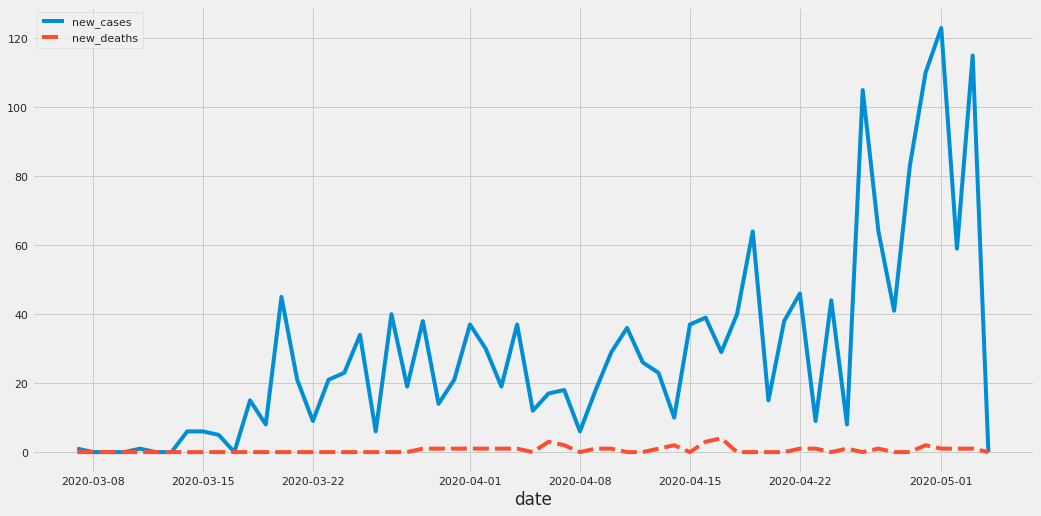

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-03-20 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-20 00:00:00, population_size=3015268.0, initially_infected=1305.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-20,3.013963e+06,1305.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1305.000000,1305.000000
2020-03-21,3.013963e+06,130.500000,0.000000,1174.500000,1174.500000,0.000000,0.000000,1305.000000,1305.000000
2020-03-22,3.013024e+06,952.243344,939.193344,939.600000,117.450000,352.350000,352.350000,1891.843344,2244.193344
2020-03-23,3.012273e+06,846.344877,751.120542,1514.739009,857.019009,634.230000,281.880000,2361.083886,2995.313886
2020-03-24,3.011062e+06,1295.221923,1210.587435,1822.027695,761.710389,1088.651703,454.421703,3117.249618,4205.901321


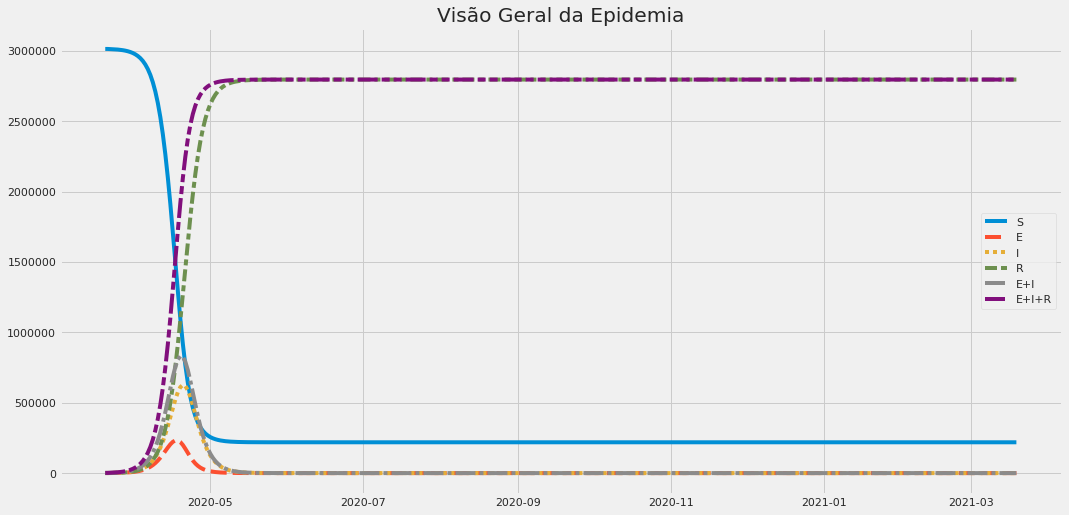

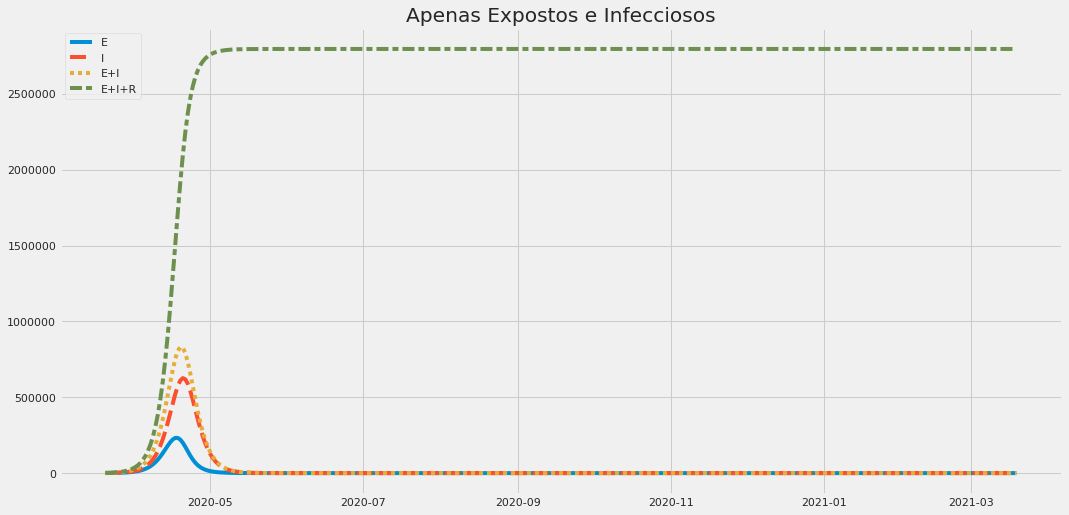

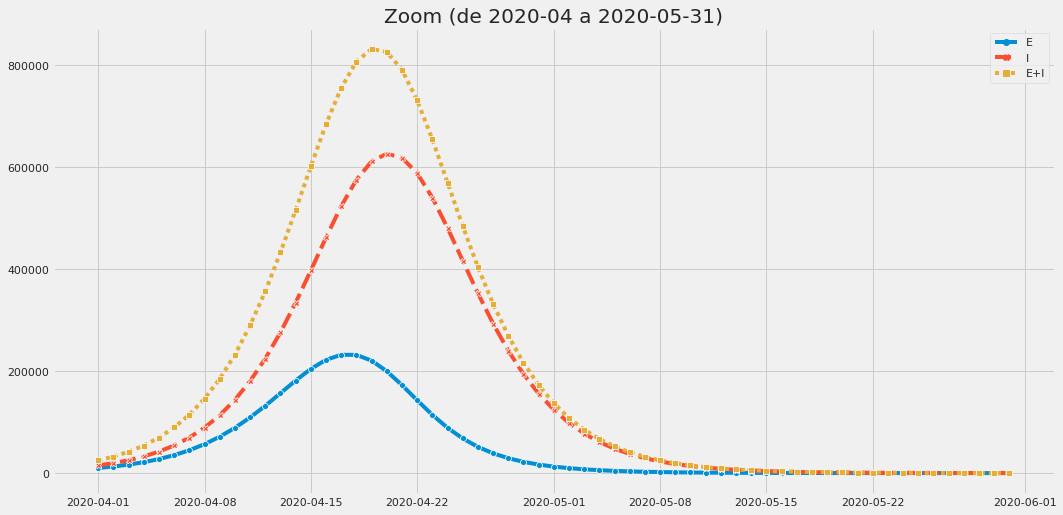

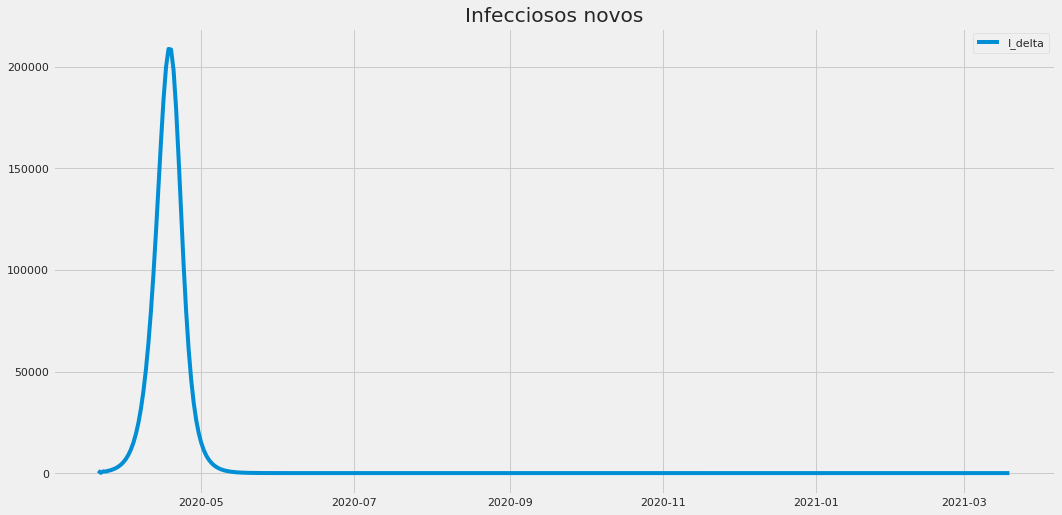

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

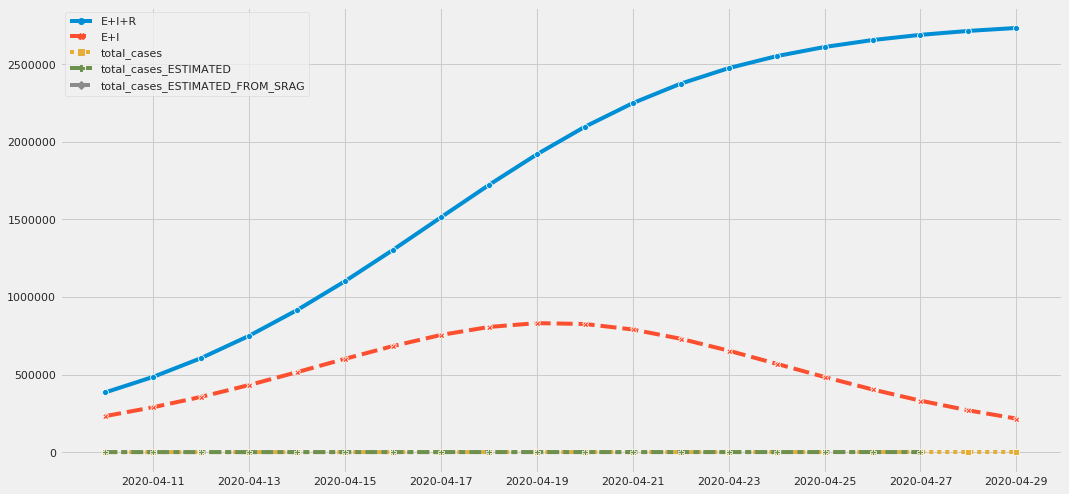

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-20,3.013963e+06,1305.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1305.000000,1305.000000
2020-03-21,3.013963e+06,0.000000,0.000000,1305.000000,1305.000000,0.000000,0.000000,1305.000000,1305.000000
2020-03-22,3.012789e+06,1173.991680,1173.991680,783.000000,0.000000,522.000000,522.000000,1956.991680,2478.991680
2020-03-23,3.012085e+06,704.120633,704.120633,1643.791680,1173.991680,835.200000,313.200000,2347.912313,3183.112313
2020-03-24,3.010607e+06,1477.850748,1477.850748,1690.395641,704.120633,1492.716672,657.516672,3168.246389,4660.963061


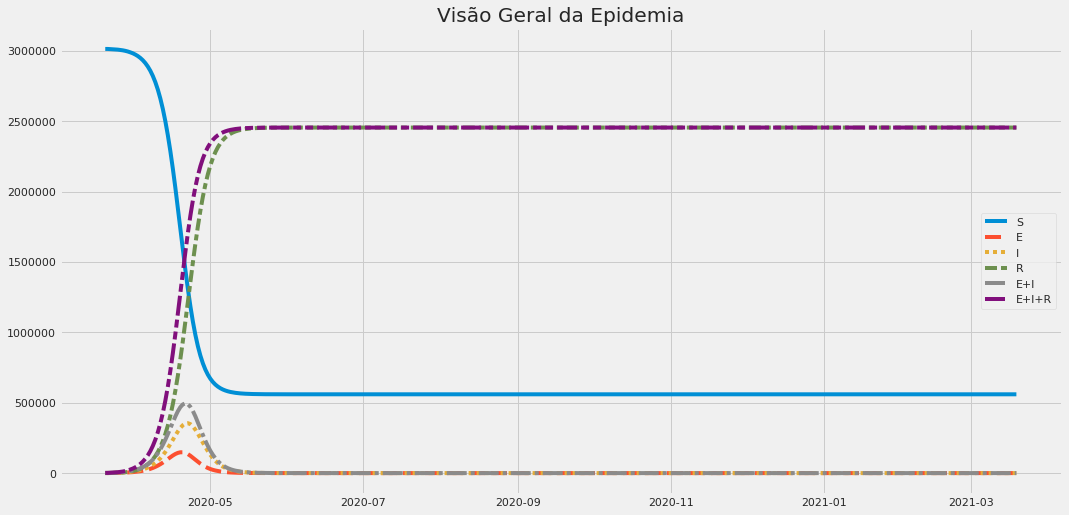

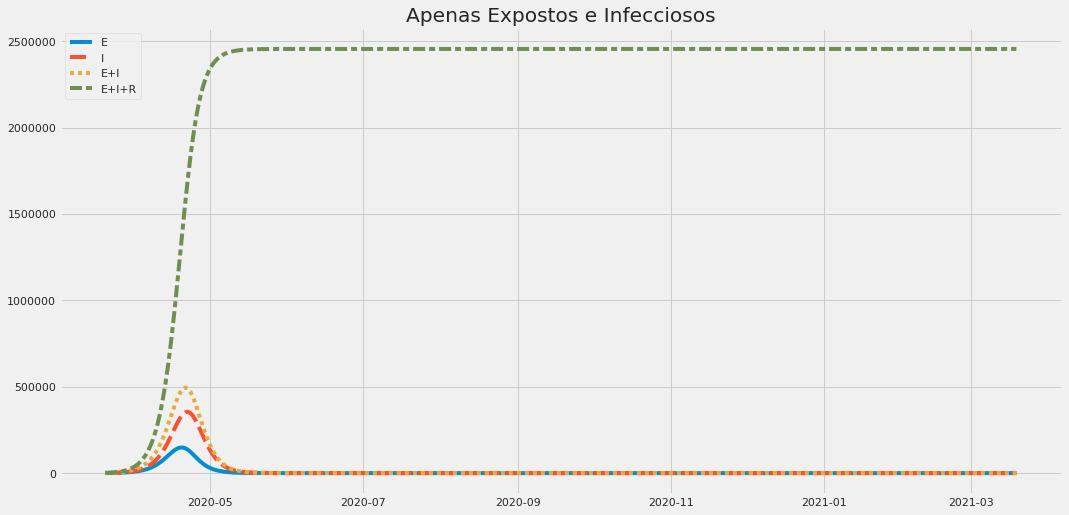

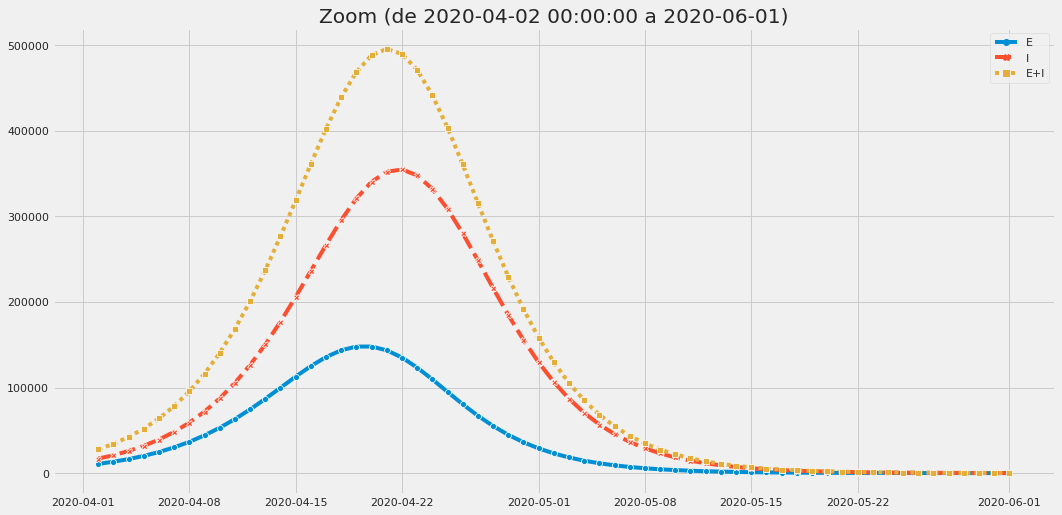

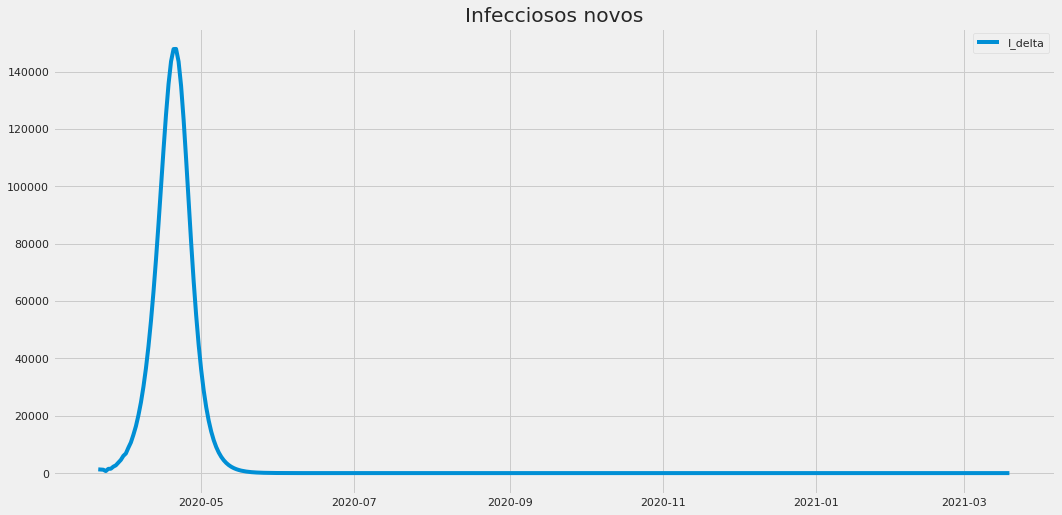

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

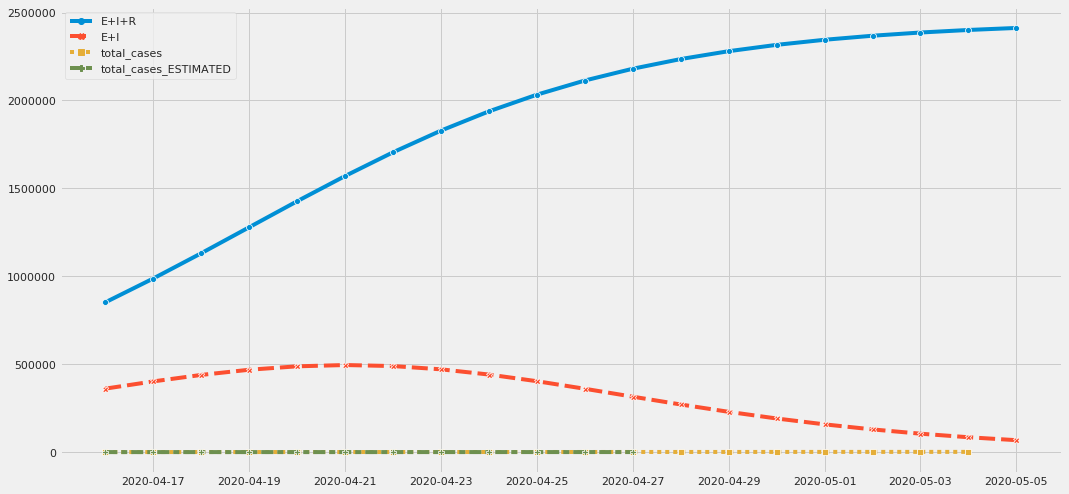

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 10/1000 [00:00<00:11, 89.54trial/s, best loss: 946.8832991265243]

  2%|▏         | 20/1000 [00:00<00:10, 91.67trial/s, best loss: 373.0700032581817]

  3%|▎         | 28/1000 [00:00<00:11, 85.77trial/s, best loss: 225.81364928583446]

  4%|▎         | 35/1000 [00:00<00:12, 75.97trial/s, best loss: 225.81364928583446]

  4%|▍         | 42/1000 [00:00<00:13, 68.55trial/s, best loss: 225.81364928583446]

  5%|▍         | 48/1000 [00:00<00:14, 65.38trial/s, best loss: 182.1042112909038] 

  6%|▌         | 56/1000 [00:00<00:13, 67.91trial/s, best loss: 182.1042112909038]

  6%|▋         | 64/1000 [00:00<00:13, 68.36trial/s, best loss: 135.00732269602116]

  7%|▋         | 71/1000 [00:00<00:13, 67.01trial/s, best loss: 135.00732269602116]

  8%|▊         | 78/1000 [00:01<00:13, 66.41trial/s, best loss: 135.00732269602116]

  8%|▊         | 85/1000 [00:01<00:14, 61.99trial/s, best loss: 135.00732269602116]

  9%|▉         | 92/1000 [00:01<00:14, 62.86trial/s, best loss: 135.00732269602116]

 10%|▉         | 99/1000 [00:01<00:14, 62.51trial/s, best loss: 135.00732269602116]

 11%|█         | 106/1000 [00:01<00:14, 62.26trial/s, best loss: 135.00732269602116]

 11%|█▏        | 113/1000 [00:01<00:14, 63.07trial/s, best loss: 135.00732269602116]

 12%|█▏        | 120/1000 [00:01<00:13, 63.57trial/s, best loss: 101.51285144529837]

 13%|█▎        | 127/1000 [00:01<00:13, 64.68trial/s, best loss: 101.51285144529837]

 13%|█▎        | 134/1000 [00:01<00:13, 64.67trial/s, best loss: 101.51285144529837]

 14%|█▍        | 141/1000 [00:02<00:13, 62.11trial/s, best loss: 101.51285144529837]

 15%|█▍        | 148/1000 [00:02<00:13, 62.18trial/s, best loss: 101.51285144529837]

 16%|█▌        | 155/1000 [00:02<00:13, 61.99trial/s, best loss: 101.51285144529837]

 16%|█▌        | 162/1000 [00:02<00:13, 62.55trial/s, best loss: 101.51285144529837]

 17%|█▋        | 169/1000 [00:02<00:14, 59.25trial/s, best loss: 101.51285144529837]

 18%|█▊        | 175/1000 [00:02<00:14, 57.42trial/s, best loss: 101.51285144529837]

 18%|█▊        | 182/1000 [00:02<00:13, 59.81trial/s, best loss: 101.51285144529837]

 19%|█▉        | 189/1000 [00:02<00:13, 61.19trial/s, best loss: 101.51285144529837]

 20%|█▉        | 196/1000 [00:03<00:12, 62.83trial/s, best loss: 101.51285144529837]

 20%|██        | 203/1000 [00:03<00:12, 61.78trial/s, best loss: 101.51285144529837]

 21%|██        | 210/1000 [00:03<00:13, 56.72trial/s, best loss: 101.51285144529837]

 22%|██▏       | 217/1000 [00:03<00:13, 59.50trial/s, best loss: 101.51285144529837]

 22%|██▏       | 224/1000 [00:03<00:12, 60.32trial/s, best loss: 101.51285144529837]

 23%|██▎       | 231/1000 [00:03<00:13, 57.55trial/s, best loss: 101.51285144529837]

 24%|██▎       | 237/1000 [00:03<00:14, 51.26trial/s, best loss: 101.51285144529837]

 24%|██▍       | 243/1000 [00:03<00:15, 47.55trial/s, best loss: 101.51285144529837]

 25%|██▌       | 250/1000 [00:04<00:14, 51.37trial/s, best loss: 101.51285144529837]

 26%|██▌       | 257/1000 [00:04<00:13, 53.78trial/s, best loss: 101.51285144529837]

 26%|██▋       | 264/1000 [00:04<00:13, 56.59trial/s, best loss: 101.51285144529837]

 27%|██▋       | 271/1000 [00:04<00:12, 57.82trial/s, best loss: 101.51285144529837]

 28%|██▊       | 277/1000 [00:04<00:12, 58.13trial/s, best loss: 101.51285144529837]

 28%|██▊       | 283/1000 [00:04<00:12, 57.82trial/s, best loss: 84.22792298350113] 

 29%|██▉       | 289/1000 [00:04<00:12, 57.57trial/s, best loss: 84.22792298350113]

 30%|██▉       | 295/1000 [00:04<00:12, 56.85trial/s, best loss: 84.22792298350113]

 30%|███       | 301/1000 [00:04<00:12, 57.52trial/s, best loss: 84.22792298350113]

 31%|███       | 308/1000 [00:05<00:11, 58.42trial/s, best loss: 84.22792298350113]

 31%|███▏      | 314/1000 [00:05<00:12, 55.36trial/s, best loss: 84.22792298350113]

 32%|███▏      | 320/1000 [00:05<00:12, 56.07trial/s, best loss: 84.22792298350113]

 33%|███▎      | 327/1000 [00:05<00:11, 57.54trial/s, best loss: 84.22792298350113]

 33%|███▎      | 333/1000 [00:05<00:11, 57.58trial/s, best loss: 84.22792298350113]

 34%|███▍      | 340/1000 [00:05<00:11, 58.63trial/s, best loss: 84.22792298350113]

 35%|███▍      | 346/1000 [00:05<00:11, 56.40trial/s, best loss: 84.22792298350113]

 35%|███▌      | 352/1000 [00:05<00:11, 55.48trial/s, best loss: 84.22792298350113]

 36%|███▌      | 358/1000 [00:05<00:12, 52.48trial/s, best loss: 84.22792298350113]

 36%|███▋      | 364/1000 [00:06<00:12, 52.09trial/s, best loss: 84.22792298350113]

 37%|███▋      | 370/1000 [00:06<00:12, 51.34trial/s, best loss: 84.22792298350113]

 38%|███▊      | 376/1000 [00:06<00:12, 51.95trial/s, best loss: 84.22792298350113]

 38%|███▊      | 382/1000 [00:06<00:13, 44.79trial/s, best loss: 84.15241036148548]

 39%|███▉      | 388/1000 [00:06<00:12, 47.13trial/s, best loss: 84.15241036148548]

 39%|███▉      | 393/1000 [00:06<00:13, 46.01trial/s, best loss: 84.15241036148548]

 40%|███▉      | 398/1000 [00:06<00:14, 41.60trial/s, best loss: 84.15241036148548]

 40%|████      | 403/1000 [00:06<00:15, 39.07trial/s, best loss: 84.15241036148548]

 41%|████      | 408/1000 [00:07<00:16, 34.94trial/s, best loss: 84.15241036148548]

 41%|████▏     | 413/1000 [00:07<00:15, 36.82trial/s, best loss: 84.15241036148548]

 42%|████▏     | 417/1000 [00:07<00:17, 33.50trial/s, best loss: 84.15241036148548]

 42%|████▏     | 421/1000 [00:07<00:16, 34.83trial/s, best loss: 84.15241036148548]

 43%|████▎     | 426/1000 [00:07<00:15, 36.92trial/s, best loss: 84.15241036148548]

 43%|████▎     | 430/1000 [00:07<00:15, 37.57trial/s, best loss: 84.15241036148548]

 43%|████▎     | 434/1000 [00:07<00:15, 37.04trial/s, best loss: 84.15241036148548]

 44%|████▍     | 438/1000 [00:07<00:15, 35.87trial/s, best loss: 84.15241036148548]

 44%|████▍     | 442/1000 [00:08<00:15, 36.40trial/s, best loss: 84.15241036148548]

 45%|████▍     | 446/1000 [00:08<00:16, 33.43trial/s, best loss: 84.15241036148548]

 45%|████▌     | 451/1000 [00:08<00:15, 35.79trial/s, best loss: 84.15241036148548]

 46%|████▌     | 456/1000 [00:08<00:13, 38.89trial/s, best loss: 84.15241036148548]

 46%|████▌     | 462/1000 [00:08<00:12, 41.61trial/s, best loss: 84.15241036148548]

 47%|████▋     | 467/1000 [00:08<00:12, 41.37trial/s, best loss: 84.15241036148548]

 47%|████▋     | 472/1000 [00:08<00:13, 39.89trial/s, best loss: 84.15241036148548]

 48%|████▊     | 477/1000 [00:08<00:12, 41.31trial/s, best loss: 84.15241036148548]

 48%|████▊     | 482/1000 [00:09<00:12, 41.83trial/s, best loss: 84.15241036148548]

 49%|████▊     | 487/1000 [00:09<00:12, 42.23trial/s, best loss: 84.15241036148548]

 49%|████▉     | 492/1000 [00:09<00:12, 40.14trial/s, best loss: 84.15241036148548]

 50%|████▉     | 497/1000 [00:09<00:12, 40.62trial/s, best loss: 84.15241036148548]

 50%|█████     | 502/1000 [00:09<00:12, 41.37trial/s, best loss: 84.15241036148548]

 51%|█████     | 507/1000 [00:09<00:11, 41.93trial/s, best loss: 84.15241036148548]

 51%|█████     | 512/1000 [00:09<00:11, 43.69trial/s, best loss: 84.15241036148548]

 52%|█████▏    | 518/1000 [00:09<00:10, 45.49trial/s, best loss: 84.15241036148548]

 52%|█████▏    | 524/1000 [00:09<00:10, 46.87trial/s, best loss: 84.15241036148548]

 53%|█████▎    | 530/1000 [00:10<00:09, 47.73trial/s, best loss: 84.15241036148548]

 54%|█████▎    | 535/1000 [00:10<00:10, 45.21trial/s, best loss: 84.15241036148548]

 54%|█████▍    | 540/1000 [00:10<00:10, 44.94trial/s, best loss: 84.15241036148548]

 55%|█████▍    | 545/1000 [00:10<00:10, 43.34trial/s, best loss: 84.15241036148548]

 55%|█████▌    | 550/1000 [00:10<00:10, 44.97trial/s, best loss: 84.15241036148548]

 56%|█████▌    | 555/1000 [00:10<00:09, 45.75trial/s, best loss: 84.15241036148548]

 56%|█████▌    | 560/1000 [00:10<00:09, 46.56trial/s, best loss: 84.15241036148548]

 56%|█████▋    | 565/1000 [00:10<00:09, 47.12trial/s, best loss: 84.15241036148548]

 57%|█████▋    | 571/1000 [00:11<00:08, 48.47trial/s, best loss: 84.15241036148548]

 58%|█████▊    | 576/1000 [00:11<00:09, 45.09trial/s, best loss: 84.15241036148548]

 58%|█████▊    | 582/1000 [00:11<00:08, 46.80trial/s, best loss: 84.15241036148548]

 59%|█████▉    | 588/1000 [00:11<00:08, 48.77trial/s, best loss: 84.15241036148548]

 59%|█████▉    | 593/1000 [00:11<00:08, 48.08trial/s, best loss: 84.15241036148548]

 60%|█████▉    | 598/1000 [00:11<00:08, 48.18trial/s, best loss: 84.15241036148548]

 60%|██████    | 603/1000 [00:11<00:08, 45.93trial/s, best loss: 84.15241036148548]

 61%|██████    | 608/1000 [00:11<00:08, 45.77trial/s, best loss: 84.15241036148548]

 61%|██████▏   | 613/1000 [00:11<00:08, 44.59trial/s, best loss: 84.15241036148548]

 62%|██████▏   | 618/1000 [00:12<00:08, 44.90trial/s, best loss: 84.15241036148548]

 62%|██████▏   | 623/1000 [00:12<00:08, 44.21trial/s, best loss: 84.15241036148548]

 63%|██████▎   | 628/1000 [00:12<00:08, 44.55trial/s, best loss: 84.15241036148548]

 63%|██████▎   | 633/1000 [00:12<00:08, 44.68trial/s, best loss: 84.15241036148548]

 64%|██████▍   | 638/1000 [00:12<00:07, 45.84trial/s, best loss: 84.15241036148548]

 64%|██████▍   | 643/1000 [00:12<00:07, 45.09trial/s, best loss: 84.15241036148548]

 65%|██████▍   | 648/1000 [00:12<00:07, 44.17trial/s, best loss: 84.15241036148548]

 65%|██████▌   | 653/1000 [00:12<00:07, 44.62trial/s, best loss: 84.15241036148548]

 66%|██████▌   | 658/1000 [00:12<00:07, 45.09trial/s, best loss: 84.15241036148548]

 66%|██████▋   | 663/1000 [00:13<00:07, 45.83trial/s, best loss: 84.15241036148548]

 67%|██████▋   | 668/1000 [00:13<00:07, 42.74trial/s, best loss: 84.15241036148548]

 67%|██████▋   | 673/1000 [00:13<00:08, 40.33trial/s, best loss: 84.15241036148548]

 68%|██████▊   | 678/1000 [00:13<00:07, 40.36trial/s, best loss: 84.15241036148548]

 68%|██████▊   | 683/1000 [00:13<00:07, 41.80trial/s, best loss: 84.15241036148548]

 69%|██████▉   | 688/1000 [00:13<00:07, 41.22trial/s, best loss: 84.15241036148548]

 69%|██████▉   | 693/1000 [00:13<00:07, 41.74trial/s, best loss: 84.15241036148548]

 70%|██████▉   | 698/1000 [00:13<00:07, 42.81trial/s, best loss: 84.15241036148548]

 70%|███████   | 703/1000 [00:13<00:06, 44.63trial/s, best loss: 84.15241036148548]

 71%|███████   | 708/1000 [00:14<00:06, 45.67trial/s, best loss: 84.15241036148548]

 71%|███████▏  | 713/1000 [00:14<00:06, 44.66trial/s, best loss: 84.15241036148548]

 72%|███████▏  | 718/1000 [00:14<00:06, 45.71trial/s, best loss: 84.15241036148548]

 72%|███████▏  | 723/1000 [00:14<00:06, 40.79trial/s, best loss: 84.15241036148548]

 73%|███████▎  | 729/1000 [00:14<00:06, 43.76trial/s, best loss: 84.15241036148548]

 73%|███████▎  | 734/1000 [00:14<00:05, 45.11trial/s, best loss: 84.15241036148548]

 74%|███████▍  | 739/1000 [00:14<00:05, 46.21trial/s, best loss: 84.15241036148548]

 74%|███████▍  | 744/1000 [00:14<00:05, 47.04trial/s, best loss: 84.15241036148548]

 75%|███████▍  | 749/1000 [00:14<00:05, 47.44trial/s, best loss: 84.15241036148548]

 75%|███████▌  | 754/1000 [00:15<00:05, 46.32trial/s, best loss: 84.15241036148548]

 76%|███████▌  | 759/1000 [00:15<00:05, 46.46trial/s, best loss: 84.15241036148548]

 76%|███████▋  | 764/1000 [00:15<00:05, 46.56trial/s, best loss: 84.15241036148548]

 77%|███████▋  | 769/1000 [00:15<00:04, 47.54trial/s, best loss: 84.15241036148548]

 77%|███████▋  | 774/1000 [00:15<00:04, 47.12trial/s, best loss: 84.15241036148548]

 78%|███████▊  | 779/1000 [00:15<00:04, 45.40trial/s, best loss: 84.15241036148548]

 78%|███████▊  | 784/1000 [00:15<00:04, 44.82trial/s, best loss: 84.15241036148548]

 79%|███████▉  | 789/1000 [00:15<00:05, 39.11trial/s, best loss: 84.15241036148548]

 79%|███████▉  | 794/1000 [00:16<00:04, 41.55trial/s, best loss: 84.15241036148548]

 80%|███████▉  | 799/1000 [00:16<00:04, 42.28trial/s, best loss: 84.15241036148548]

 80%|████████  | 804/1000 [00:16<00:04, 43.80trial/s, best loss: 84.15241036148548]

 81%|████████  | 809/1000 [00:16<00:04, 43.81trial/s, best loss: 84.15241036148548]

 81%|████████▏ | 814/1000 [00:16<00:04, 43.61trial/s, best loss: 84.15241036148548]

 82%|████████▏ | 819/1000 [00:16<00:04, 44.05trial/s, best loss: 84.15241036148548]

 82%|████████▏ | 824/1000 [00:16<00:03, 44.19trial/s, best loss: 84.15241036148548]

 83%|████████▎ | 829/1000 [00:16<00:03, 44.75trial/s, best loss: 84.15241036148548]

 83%|████████▎ | 834/1000 [00:16<00:03, 45.06trial/s, best loss: 84.15241036148548]

 84%|████████▍ | 839/1000 [00:17<00:03, 45.71trial/s, best loss: 84.15241036148548]

 84%|████████▍ | 844/1000 [00:17<00:03, 45.31trial/s, best loss: 84.15241036148548]

 85%|████████▍ | 849/1000 [00:17<00:03, 46.08trial/s, best loss: 84.15241036148548]

 85%|████████▌ | 854/1000 [00:17<00:03, 45.84trial/s, best loss: 84.15241036148548]

 86%|████████▌ | 859/1000 [00:17<00:03, 45.57trial/s, best loss: 84.15241036148548]

 86%|████████▋ | 864/1000 [00:17<00:03, 41.33trial/s, best loss: 84.15241036148548]

 87%|████████▋ | 869/1000 [00:17<00:03, 42.63trial/s, best loss: 84.15241036148548]

 87%|████████▋ | 874/1000 [00:17<00:02, 42.95trial/s, best loss: 84.15241036148548]

 88%|████████▊ | 879/1000 [00:17<00:02, 43.50trial/s, best loss: 84.15241036148548]

 88%|████████▊ | 884/1000 [00:18<00:02, 43.48trial/s, best loss: 84.15241036148548]

 89%|████████▉ | 889/1000 [00:18<00:02, 41.37trial/s, best loss: 84.15241036148548]

 89%|████████▉ | 894/1000 [00:18<00:02, 42.39trial/s, best loss: 84.15241036148548]

 90%|████████▉ | 899/1000 [00:18<00:02, 44.05trial/s, best loss: 84.15241036148548]

 90%|█████████ | 904/1000 [00:18<00:02, 45.33trial/s, best loss: 84.15241036148548]

 91%|█████████ | 909/1000 [00:18<00:01, 45.73trial/s, best loss: 84.15241036148548]

 91%|█████████▏| 914/1000 [00:18<00:01, 45.02trial/s, best loss: 84.15241036148548]

 92%|█████████▏| 919/1000 [00:18<00:01, 45.01trial/s, best loss: 83.68416690538707]

 92%|█████████▏| 924/1000 [00:18<00:01, 45.59trial/s, best loss: 83.68416690538707]

 93%|█████████▎| 929/1000 [00:19<00:01, 46.40trial/s, best loss: 83.68416690538707]

 93%|█████████▎| 934/1000 [00:19<00:01, 45.69trial/s, best loss: 83.68416690538707]

 94%|█████████▍| 939/1000 [00:19<00:01, 45.83trial/s, best loss: 83.68416690538707]

 94%|█████████▍| 944/1000 [00:19<00:01, 46.26trial/s, best loss: 83.68416690538707]

 95%|█████████▍| 949/1000 [00:19<00:01, 46.51trial/s, best loss: 83.68416690538707]

 95%|█████████▌| 954/1000 [00:19<00:00, 46.69trial/s, best loss: 83.68416690538707]

 96%|█████████▌| 959/1000 [00:19<00:00, 46.21trial/s, best loss: 82.8791024713299] 

 96%|█████████▋| 964/1000 [00:19<00:00, 46.70trial/s, best loss: 82.8791024713299]

 97%|█████████▋| 969/1000 [00:19<00:00, 46.79trial/s, best loss: 82.8791024713299]

 97%|█████████▋| 974/1000 [00:20<00:00, 46.93trial/s, best loss: 82.8791024713299]

 98%|█████████▊| 979/1000 [00:20<00:00, 45.99trial/s, best loss: 82.8791024713299]

 98%|█████████▊| 984/1000 [00:20<00:00, 46.24trial/s, best loss: 82.8791024713299]

 99%|█████████▉| 989/1000 [00:20<00:00, 46.23trial/s, best loss: 82.8791024713299]

 99%|█████████▉| 994/1000 [00:20<00:00, 46.23trial/s, best loss: 82.8791024713299]

100%|█████████▉| 999/1000 [00:20<00:00, 46.26trial/s, best loss: 82.8791024713299]

100%|██████████| 1000/1000 [00:20<00:00, 48.56trial/s, best loss: 82.8791024713299]


Best parameters found: {'alpha': 0.9932613795282604, 'beta': 0.33996991893624295, 'gamma': 0.31021632556298673}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-20,3.013963e+06,1305.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1305.000000,1305.000000
2020-03-21,3.013963e+06,8.793900,0.000000,1296.206100,1296.206100,0.000000,0.000000,1305.000000,1305.000000
2020-03-22,3.013523e+06,440.539620,440.480362,902.836448,8.734641,402.104294,402.104294,1343.376068,1745.480362
2020-03-23,3.013216e+06,309.728183,306.759554,1060.332833,437.570991,682.178899,280.074605,1370.061016,2052.239915
2020-03-24,3.012856e+06,362.323059,360.235918,1039.041320,307.641043,1011.111454,328.932555,1401.364379,2412.475833


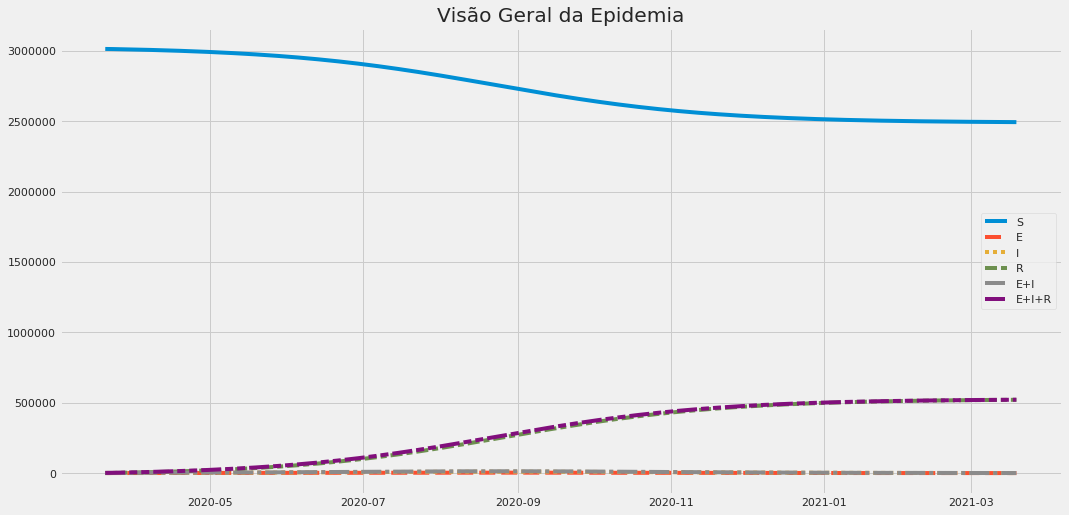

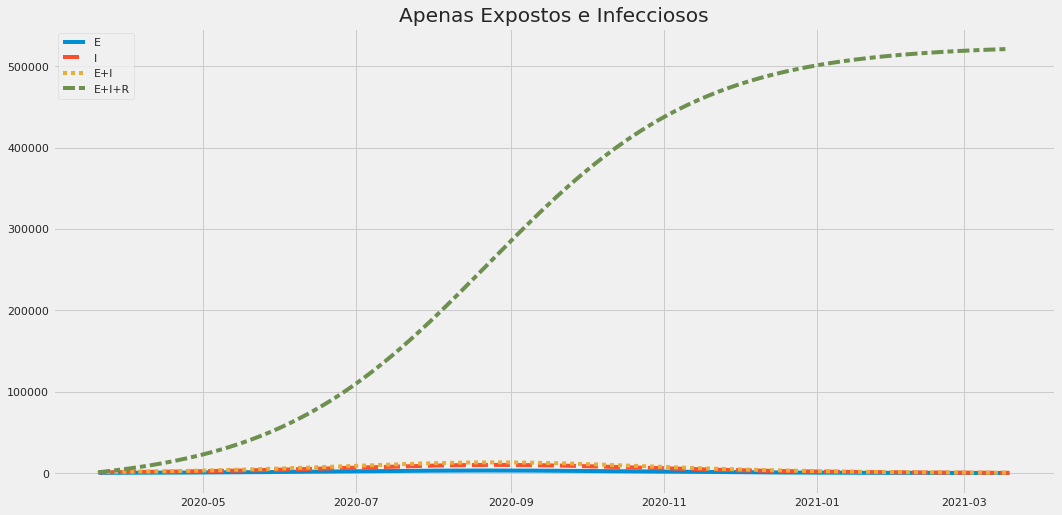

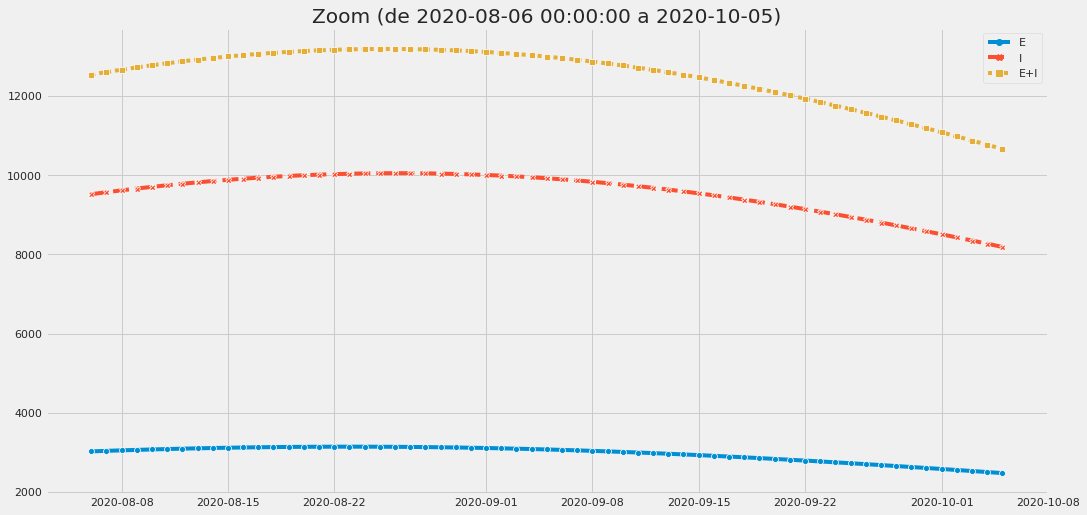

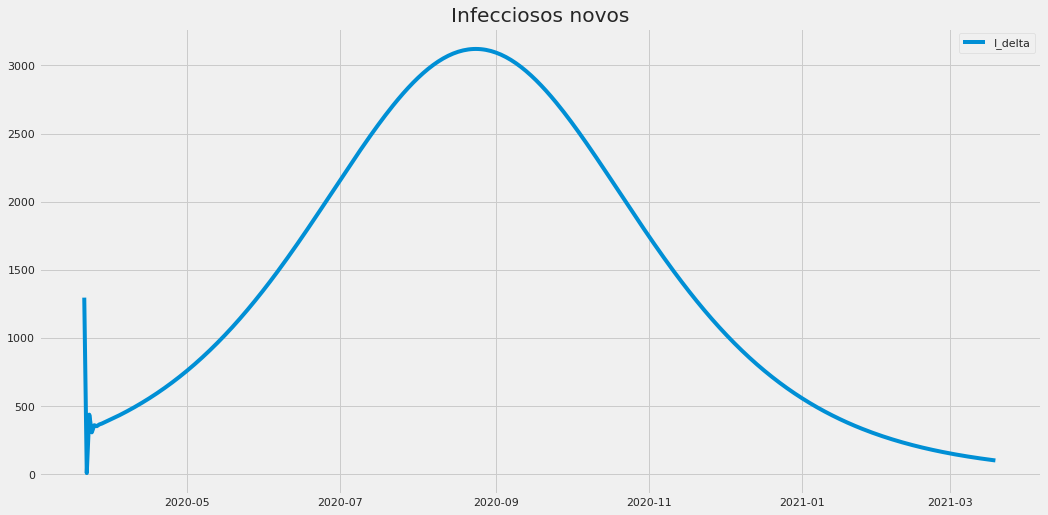

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,110,2,1423,30,3015268.0,NaN,21345,NaN
2020-05-01,123,1,1546,31,3015268.0,NaN,23190,NaN
2020-05-02,59,1,1605,32,3015268.0,NaN,24075,NaN
2020-05-03,115,1,1720,33,3015268.0,NaN,25800,NaN
2020-05-04,0,0,1720,33,3015268.0,NaN,25800,NaN


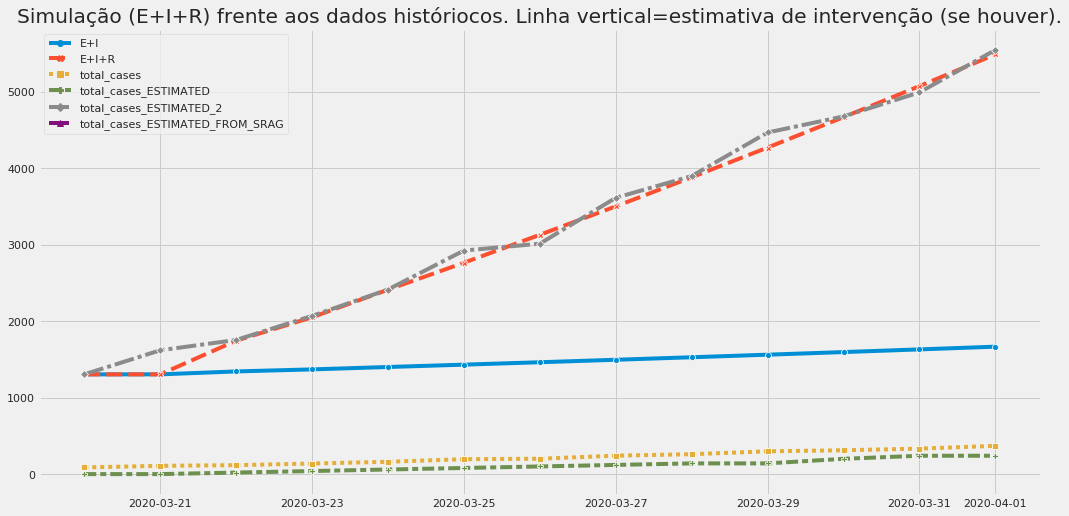

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 9/3000 [00:00<00:35, 83.85trial/s, best loss: 3100.376792418665]

  1%|          | 18/3000 [00:00<00:34, 85.30trial/s, best loss: 3100.376792418665]

  1%|          | 24/3000 [00:00<00:39, 74.77trial/s, best loss: 3100.376792418665]

  1%|          | 29/3000 [00:00<00:46, 64.45trial/s, best loss: 3100.376792418665]

  1%|          | 34/3000 [00:00<00:51, 57.71trial/s, best loss: 2909.2404605092893]

  1%|▏         | 39/3000 [00:00<00:58, 50.60trial/s, best loss: 2909.2404605092893]

  1%|▏         | 44/3000 [00:00<01:10, 42.14trial/s, best loss: 1245.8019641283902]

  2%|▏         | 49/3000 [00:00<01:07, 43.41trial/s, best loss: 1245.8019641283902]

  2%|▏         | 54/3000 [00:01<01:07, 43.56trial/s, best loss: 1245.8019641283902]

  2%|▏         | 59/3000 [00:01<01:07, 43.47trial/s, best loss: 1245.8019641283902]

  2%|▏         | 64/3000 [00:01<01:05, 44.49trial/s, best loss: 1245.8019641283902]

  2%|▏         | 69/3000 [00:01<01:05, 44.58trial/s, best loss: 1245.8019641283902]

  2%|▏         | 74/3000 [00:01<01:05, 44.88trial/s, best loss: 1245.8019641283902]

  3%|▎         | 79/3000 [00:01<01:07, 43.58trial/s, best loss: 1245.8019641283902]

  3%|▎         | 84/3000 [00:01<01:07, 43.20trial/s, best loss: 1245.8019641283902]

  3%|▎         | 89/3000 [00:01<01:07, 43.00trial/s, best loss: 1245.8019641283902]

  3%|▎         | 94/3000 [00:01<01:07, 42.89trial/s, best loss: 1245.8019641283902]

  3%|▎         | 99/3000 [00:02<01:08, 42.10trial/s, best loss: 1245.8019641283902]

  3%|▎         | 104/3000 [00:02<01:09, 41.88trial/s, best loss: 1245.8019641283902]

  4%|▎         | 109/3000 [00:02<01:08, 42.31trial/s, best loss: 1245.8019641283902]

  4%|▍         | 114/3000 [00:02<01:15, 38.31trial/s, best loss: 1245.8019641283902]

  4%|▍         | 118/3000 [00:02<01:15, 38.26trial/s, best loss: 1245.8019641283902]

  4%|▍         | 122/3000 [00:02<01:14, 38.55trial/s, best loss: 1245.8019641283902]

  4%|▍         | 126/3000 [00:02<01:14, 38.41trial/s, best loss: 1245.8019641283902]

  4%|▍         | 131/3000 [00:02<01:11, 39.91trial/s, best loss: 1245.8019641283902]

  5%|▍         | 136/3000 [00:03<01:10, 40.59trial/s, best loss: 1245.8019641283902]

  5%|▍         | 141/3000 [00:03<01:11, 40.25trial/s, best loss: 1245.8019641283902]

  5%|▍         | 146/3000 [00:03<01:10, 40.75trial/s, best loss: 1245.8019641283902]

  5%|▌         | 151/3000 [00:03<01:11, 39.99trial/s, best loss: 1245.8019641283902]

  5%|▌         | 156/3000 [00:03<01:10, 40.35trial/s, best loss: 1245.8019641283902]

  5%|▌         | 161/3000 [00:03<01:13, 38.88trial/s, best loss: 1245.8019641283902]

  6%|▌         | 165/3000 [00:03<01:13, 38.83trial/s, best loss: 1245.8019641283902]

  6%|▌         | 169/3000 [00:03<01:12, 39.14trial/s, best loss: 1245.8019641283902]

  6%|▌         | 174/3000 [00:03<01:11, 39.72trial/s, best loss: 1245.8019641283902]

  6%|▌         | 178/3000 [00:04<01:13, 38.57trial/s, best loss: 1245.8019641283902]

  6%|▌         | 182/3000 [00:04<01:19, 35.37trial/s, best loss: 1245.8019641283902]

  6%|▌         | 186/3000 [00:04<01:23, 33.70trial/s, best loss: 1245.8019641283902]

  6%|▋         | 190/3000 [00:04<01:19, 35.19trial/s, best loss: 1245.8019641283902]

  6%|▋         | 194/3000 [00:04<01:18, 35.66trial/s, best loss: 1245.8019641283902]

  7%|▋         | 198/3000 [00:04<01:16, 36.65trial/s, best loss: 1245.8019641283902]

  7%|▋         | 202/3000 [00:04<01:14, 37.34trial/s, best loss: 1245.8019641283902]

  7%|▋         | 206/3000 [00:04<01:22, 33.97trial/s, best loss: 1245.8019641283902]

  7%|▋         | 211/3000 [00:05<01:18, 35.64trial/s, best loss: 1245.8019641283902]

  7%|▋         | 215/3000 [00:05<01:17, 35.96trial/s, best loss: 1245.8019641283902]

  7%|▋         | 219/3000 [00:05<01:15, 36.66trial/s, best loss: 1245.8019641283902]

  7%|▋         | 223/3000 [00:05<01:18, 35.40trial/s, best loss: 1245.8019641283902]

  8%|▊         | 227/3000 [00:05<01:19, 34.79trial/s, best loss: 1245.8019641283902]

  8%|▊         | 231/3000 [00:05<01:22, 33.50trial/s, best loss: 724.1287603517254] 

  8%|▊         | 235/3000 [00:05<01:19, 34.77trial/s, best loss: 724.1287603517254]

  8%|▊         | 239/3000 [00:05<01:17, 35.65trial/s, best loss: 724.1287603517254]

  8%|▊         | 243/3000 [00:05<01:18, 35.09trial/s, best loss: 724.1287603517254]

  8%|▊         | 247/3000 [00:06<01:19, 34.46trial/s, best loss: 724.1287603517254]

  8%|▊         | 251/3000 [00:06<01:23, 33.12trial/s, best loss: 724.1287603517254]

  8%|▊         | 255/3000 [00:06<01:22, 33.31trial/s, best loss: 724.1287603517254]

  9%|▊         | 259/3000 [00:06<01:21, 33.49trial/s, best loss: 724.1287603517254]

  9%|▉         | 263/3000 [00:06<01:22, 33.23trial/s, best loss: 724.1287603517254]

  9%|▉         | 267/3000 [00:06<01:19, 34.54trial/s, best loss: 724.1287603517254]

  9%|▉         | 271/3000 [00:06<01:17, 35.11trial/s, best loss: 724.1287603517254]

  9%|▉         | 275/3000 [00:06<01:16, 35.42trial/s, best loss: 724.1287603517254]

  9%|▉         | 279/3000 [00:06<01:15, 35.93trial/s, best loss: 724.1287603517254]

  9%|▉         | 283/3000 [00:07<01:15, 35.81trial/s, best loss: 724.1287603517254]

 10%|▉         | 287/3000 [00:07<01:16, 35.58trial/s, best loss: 724.1287603517254]

 10%|▉         | 291/3000 [00:07<01:18, 34.57trial/s, best loss: 724.1287603517254]

 10%|▉         | 295/3000 [00:07<01:17, 35.03trial/s, best loss: 724.1287603517254]

 10%|▉         | 299/3000 [00:07<01:21, 33.21trial/s, best loss: 724.1287603517254]

 10%|█         | 303/3000 [00:07<01:20, 33.55trial/s, best loss: 724.1287603517254]

 10%|█         | 307/3000 [00:07<01:19, 33.96trial/s, best loss: 724.1287603517254]

 10%|█         | 311/3000 [00:07<01:17, 34.60trial/s, best loss: 724.1287603517254]

 10%|█         | 315/3000 [00:08<01:17, 34.79trial/s, best loss: 724.1287603517254]

 11%|█         | 319/3000 [00:08<01:17, 34.64trial/s, best loss: 724.1287603517254]

 11%|█         | 323/3000 [00:08<01:16, 34.81trial/s, best loss: 724.1287603517254]

 11%|█         | 327/3000 [00:08<01:24, 31.71trial/s, best loss: 724.1287603517254]

 11%|█         | 331/3000 [00:08<01:21, 32.74trial/s, best loss: 724.1287603517254]

 11%|█         | 335/3000 [00:08<01:24, 31.39trial/s, best loss: 724.1287603517254]

 11%|█▏        | 339/3000 [00:08<01:23, 31.98trial/s, best loss: 724.1287603517254]

 11%|█▏        | 343/3000 [00:08<01:21, 32.46trial/s, best loss: 724.1287603517254]

 12%|█▏        | 347/3000 [00:09<01:28, 30.10trial/s, best loss: 724.1287603517254]

 12%|█▏        | 351/3000 [00:09<01:34, 28.18trial/s, best loss: 724.1287603517254]

 12%|█▏        | 355/3000 [00:09<01:30, 29.18trial/s, best loss: 724.1287603517254]

 12%|█▏        | 359/3000 [00:09<01:28, 29.69trial/s, best loss: 724.1287603517254]

 12%|█▏        | 363/3000 [00:09<01:29, 29.51trial/s, best loss: 724.1287603517254]

 12%|█▏        | 367/3000 [00:09<01:27, 29.92trial/s, best loss: 724.1287603517254]

 12%|█▏        | 371/3000 [00:09<01:26, 30.34trial/s, best loss: 724.1287603517254]

 12%|█▎        | 375/3000 [00:10<01:35, 27.51trial/s, best loss: 724.1287603517254]

 13%|█▎        | 378/3000 [00:10<01:33, 28.03trial/s, best loss: 724.1287603517254]

 13%|█▎        | 382/3000 [00:10<01:31, 28.72trial/s, best loss: 724.1287603517254]

 13%|█▎        | 386/3000 [00:10<01:32, 28.16trial/s, best loss: 724.1287603517254]

 13%|█▎        | 389/3000 [00:10<01:45, 24.70trial/s, best loss: 724.1287603517254]

 13%|█▎        | 392/3000 [00:10<01:40, 25.90trial/s, best loss: 724.1287603517254]

 13%|█▎        | 395/3000 [00:10<01:38, 26.40trial/s, best loss: 724.1287603517254]

 13%|█▎        | 399/3000 [00:10<01:34, 27.45trial/s, best loss: 724.1287603517254]

 13%|█▎        | 402/3000 [00:11<01:32, 28.12trial/s, best loss: 724.1287603517254]

 14%|█▎        | 405/3000 [00:11<01:32, 28.00trial/s, best loss: 724.1287603517254]

 14%|█▎        | 409/3000 [00:11<01:30, 28.63trial/s, best loss: 724.1287603517254]

 14%|█▎        | 412/3000 [00:11<01:29, 28.85trial/s, best loss: 724.1287603517254]

 14%|█▍        | 415/3000 [00:11<01:29, 28.99trial/s, best loss: 724.1287603517254]

 14%|█▍        | 418/3000 [00:11<01:31, 28.34trial/s, best loss: 724.1287603517254]

 14%|█▍        | 421/3000 [00:11<01:32, 27.89trial/s, best loss: 724.1287603517254]

 14%|█▍        | 424/3000 [00:11<01:31, 28.27trial/s, best loss: 724.1287603517254]

 14%|█▍        | 427/3000 [00:11<01:30, 28.46trial/s, best loss: 724.1287603517254]

 14%|█▍        | 430/3000 [00:12<01:29, 28.61trial/s, best loss: 582.5501198430667]

 14%|█▍        | 433/3000 [00:12<01:30, 28.33trial/s, best loss: 582.5501198430667]

 15%|█▍        | 436/3000 [00:12<01:32, 27.78trial/s, best loss: 582.5501198430667]

 15%|█▍        | 439/3000 [00:12<01:35, 26.84trial/s, best loss: 582.5501198430667]

 15%|█▍        | 442/3000 [00:12<01:46, 24.12trial/s, best loss: 582.5501198430667]

 15%|█▍        | 445/3000 [00:12<01:44, 24.35trial/s, best loss: 582.5501198430667]

 15%|█▍        | 448/3000 [00:12<01:43, 24.62trial/s, best loss: 582.5501198430667]

 15%|█▌        | 451/3000 [00:12<01:39, 25.67trial/s, best loss: 582.5501198430667]

 15%|█▌        | 454/3000 [00:12<01:36, 26.44trial/s, best loss: 582.5501198430667]

 15%|█▌        | 457/3000 [00:13<01:34, 27.01trial/s, best loss: 582.5501198430667]

 15%|█▌        | 460/3000 [00:13<01:34, 26.75trial/s, best loss: 564.1317035028943]

 15%|█▌        | 463/3000 [00:13<01:32, 27.40trial/s, best loss: 564.1317035028943]

 16%|█▌        | 466/3000 [00:13<01:30, 27.90trial/s, best loss: 564.1317035028943]

 16%|█▌        | 469/3000 [00:13<01:39, 25.32trial/s, best loss: 564.1317035028943]

 16%|█▌        | 472/3000 [00:13<01:40, 25.13trial/s, best loss: 564.1317035028943]

 16%|█▌        | 475/3000 [00:13<01:42, 24.71trial/s, best loss: 564.1317035028943]

 16%|█▌        | 478/3000 [00:13<01:38, 25.68trial/s, best loss: 564.1317035028943]

 16%|█▌        | 481/3000 [00:14<01:36, 26.04trial/s, best loss: 564.1317035028943]

 16%|█▌        | 484/3000 [00:14<01:35, 26.22trial/s, best loss: 564.1317035028943]

 16%|█▌        | 487/3000 [00:14<01:35, 26.45trial/s, best loss: 564.1317035028943]

 16%|█▋        | 490/3000 [00:14<01:33, 26.78trial/s, best loss: 564.1317035028943]

 16%|█▋        | 493/3000 [00:14<01:33, 26.92trial/s, best loss: 564.1317035028943]

 17%|█▋        | 496/3000 [00:14<01:49, 22.97trial/s, best loss: 564.1317035028943]

 17%|█▋        | 499/3000 [00:14<01:49, 22.74trial/s, best loss: 564.1317035028943]

 17%|█▋        | 502/3000 [00:14<01:45, 23.66trial/s, best loss: 564.1317035028943]

 17%|█▋        | 505/3000 [00:14<01:42, 24.46trial/s, best loss: 564.1317035028943]

 17%|█▋        | 508/3000 [00:15<01:41, 24.52trial/s, best loss: 564.1317035028943]

 17%|█▋        | 511/3000 [00:15<01:40, 24.78trial/s, best loss: 564.1317035028943]

 17%|█▋        | 514/3000 [00:15<01:39, 25.03trial/s, best loss: 564.1317035028943]

 17%|█▋        | 517/3000 [00:15<01:38, 25.25trial/s, best loss: 564.1317035028943]

 17%|█▋        | 520/3000 [00:15<01:40, 24.68trial/s, best loss: 564.1317035028943]

 17%|█▋        | 523/3000 [00:15<01:38, 25.20trial/s, best loss: 564.1317035028943]

 18%|█▊        | 526/3000 [00:15<01:37, 25.44trial/s, best loss: 564.1317035028943]

 18%|█▊        | 529/3000 [00:15<01:35, 25.77trial/s, best loss: 564.1317035028943]

 18%|█▊        | 532/3000 [00:16<01:35, 25.86trial/s, best loss: 564.1317035028943]

 18%|█▊        | 535/3000 [00:16<01:37, 25.34trial/s, best loss: 564.1317035028943]

 18%|█▊        | 538/3000 [00:16<01:36, 25.43trial/s, best loss: 564.1317035028943]

 18%|█▊        | 541/3000 [00:16<01:48, 22.74trial/s, best loss: 564.1317035028943]

 18%|█▊        | 544/3000 [00:16<01:50, 22.27trial/s, best loss: 564.1317035028943]

 18%|█▊        | 547/3000 [00:16<01:45, 23.15trial/s, best loss: 564.1317035028943]

 18%|█▊        | 550/3000 [00:16<01:42, 23.80trial/s, best loss: 564.1317035028943]

 18%|█▊        | 553/3000 [00:16<01:40, 24.26trial/s, best loss: 564.1317035028943]

 19%|█▊        | 556/3000 [00:17<01:39, 24.68trial/s, best loss: 564.1317035028943]

 19%|█▊        | 559/3000 [00:17<01:39, 24.59trial/s, best loss: 564.1317035028943]

 19%|█▊        | 562/3000 [00:17<01:37, 25.05trial/s, best loss: 564.1317035028943]

 19%|█▉        | 565/3000 [00:17<01:36, 25.22trial/s, best loss: 564.1317035028943]

 19%|█▉        | 568/3000 [00:17<01:35, 25.41trial/s, best loss: 564.1317035028943]

 19%|█▉        | 571/3000 [00:17<01:38, 24.73trial/s, best loss: 564.1317035028943]

 19%|█▉        | 574/3000 [00:17<01:38, 24.66trial/s, best loss: 564.1317035028943]

 19%|█▉        | 577/3000 [00:17<01:37, 24.89trial/s, best loss: 564.1317035028943]

 19%|█▉        | 580/3000 [00:18<01:36, 25.08trial/s, best loss: 564.1317035028943]

 19%|█▉        | 583/3000 [00:18<01:37, 24.91trial/s, best loss: 564.1317035028943]

 20%|█▉        | 586/3000 [00:18<01:36, 25.04trial/s, best loss: 564.1317035028943]

 20%|█▉        | 589/3000 [00:18<01:35, 25.15trial/s, best loss: 564.1317035028943]

 20%|█▉        | 592/3000 [00:18<01:35, 25.19trial/s, best loss: 564.1317035028943]

 20%|█▉        | 595/3000 [00:18<01:36, 24.91trial/s, best loss: 564.1317035028943]

 20%|█▉        | 598/3000 [00:18<01:36, 25.01trial/s, best loss: 564.1317035028943]

 20%|██        | 601/3000 [00:18<01:35, 25.12trial/s, best loss: 564.1317035028943]

 20%|██        | 604/3000 [00:18<01:34, 25.24trial/s, best loss: 564.1317035028943]

 20%|██        | 607/3000 [00:19<01:34, 25.24trial/s, best loss: 564.1317035028943]

 20%|██        | 610/3000 [00:19<01:40, 23.90trial/s, best loss: 564.1317035028943]

 20%|██        | 613/3000 [00:19<01:38, 24.11trial/s, best loss: 564.1317035028943]

 21%|██        | 616/3000 [00:19<01:38, 24.27trial/s, best loss: 564.1317035028943]

 21%|██        | 619/3000 [00:19<01:42, 23.24trial/s, best loss: 564.1317035028943]

 21%|██        | 622/3000 [00:19<01:41, 23.39trial/s, best loss: 564.1317035028943]

 21%|██        | 625/3000 [00:19<01:40, 23.65trial/s, best loss: 564.1317035028943]

 21%|██        | 628/3000 [00:19<01:38, 24.12trial/s, best loss: 564.1317035028943]

 21%|██        | 631/3000 [00:20<01:39, 23.76trial/s, best loss: 564.1317035028943]

 21%|██        | 634/3000 [00:20<01:37, 24.20trial/s, best loss: 564.1317035028943]

 21%|██        | 637/3000 [00:20<01:37, 24.24trial/s, best loss: 564.1317035028943]

 21%|██▏       | 640/3000 [00:20<01:37, 24.22trial/s, best loss: 564.1317035028943]

 21%|██▏       | 643/3000 [00:20<01:42, 23.01trial/s, best loss: 564.1317035028943]

 22%|██▏       | 646/3000 [00:20<01:40, 23.32trial/s, best loss: 564.1317035028943]

 22%|██▏       | 649/3000 [00:20<01:39, 23.53trial/s, best loss: 564.1317035028943]

 22%|██▏       | 652/3000 [00:21<01:38, 23.83trial/s, best loss: 564.1317035028943]

 22%|██▏       | 655/3000 [00:21<01:39, 23.66trial/s, best loss: 564.1317035028943]

 22%|██▏       | 658/3000 [00:21<01:38, 23.84trial/s, best loss: 564.1317035028943]

 22%|██▏       | 661/3000 [00:21<01:37, 23.95trial/s, best loss: 564.1317035028943]

 22%|██▏       | 664/3000 [00:21<01:37, 24.02trial/s, best loss: 564.1317035028943]

 22%|██▏       | 667/3000 [00:21<01:39, 23.35trial/s, best loss: 564.1317035028943]

 22%|██▏       | 670/3000 [00:21<01:39, 23.46trial/s, best loss: 564.1317035028943]

 22%|██▏       | 673/3000 [00:21<01:40, 23.24trial/s, best loss: 564.1317035028943]

 23%|██▎       | 676/3000 [00:22<01:39, 23.35trial/s, best loss: 564.1317035028943]

 23%|██▎       | 679/3000 [00:22<01:39, 23.28trial/s, best loss: 564.1317035028943]

 23%|██▎       | 682/3000 [00:22<01:40, 23.08trial/s, best loss: 564.1317035028943]

 23%|██▎       | 685/3000 [00:22<01:40, 23.09trial/s, best loss: 564.1317035028943]

 23%|██▎       | 688/3000 [00:22<01:41, 22.69trial/s, best loss: 564.1317035028943]

 23%|██▎       | 691/3000 [00:22<01:41, 22.85trial/s, best loss: 564.1317035028943]

 23%|██▎       | 694/3000 [00:22<01:42, 22.49trial/s, best loss: 564.1317035028943]

 23%|██▎       | 697/3000 [00:22<01:42, 22.51trial/s, best loss: 564.1317035028943]

 23%|██▎       | 700/3000 [00:23<01:42, 22.46trial/s, best loss: 564.1317035028943]

 23%|██▎       | 703/3000 [00:23<01:42, 22.49trial/s, best loss: 564.1317035028943]

 24%|██▎       | 706/3000 [00:23<01:54, 20.08trial/s, best loss: 564.1317035028943]

 24%|██▎       | 709/3000 [00:23<01:49, 20.91trial/s, best loss: 564.1317035028943]

 24%|██▎       | 712/3000 [00:23<01:50, 20.79trial/s, best loss: 564.1317035028943]

 24%|██▍       | 715/3000 [00:23<01:48, 21.05trial/s, best loss: 564.1317035028943]

 24%|██▍       | 718/3000 [00:23<01:45, 21.60trial/s, best loss: 564.1317035028943]

 24%|██▍       | 721/3000 [00:24<01:44, 21.90trial/s, best loss: 564.1317035028943]

 24%|██▍       | 724/3000 [00:24<01:43, 22.01trial/s, best loss: 564.1317035028943]

 24%|██▍       | 727/3000 [00:24<01:42, 22.15trial/s, best loss: 564.1317035028943]

 24%|██▍       | 730/3000 [00:24<01:42, 22.25trial/s, best loss: 564.1317035028943]

 24%|██▍       | 733/3000 [00:24<01:44, 21.63trial/s, best loss: 564.1317035028943]

 25%|██▍       | 736/3000 [00:24<01:43, 21.86trial/s, best loss: 564.1317035028943]

 25%|██▍       | 739/3000 [00:24<01:42, 21.99trial/s, best loss: 564.1317035028943]

 25%|██▍       | 742/3000 [00:25<01:41, 22.16trial/s, best loss: 564.1317035028943]

 25%|██▍       | 745/3000 [00:25<01:43, 21.88trial/s, best loss: 564.1317035028943]

 25%|██▍       | 748/3000 [00:25<01:42, 21.97trial/s, best loss: 564.1317035028943]

 25%|██▌       | 751/3000 [00:25<01:41, 22.13trial/s, best loss: 564.1317035028943]

 25%|██▌       | 754/3000 [00:25<01:43, 21.74trial/s, best loss: 564.1317035028943]

 25%|██▌       | 757/3000 [00:25<01:43, 21.71trial/s, best loss: 564.1317035028943]

 25%|██▌       | 760/3000 [00:25<01:41, 22.11trial/s, best loss: 564.1317035028943]

 25%|██▌       | 763/3000 [00:25<01:39, 22.40trial/s, best loss: 564.1317035028943]

 26%|██▌       | 766/3000 [00:26<01:39, 22.36trial/s, best loss: 564.1317035028943]

 26%|██▌       | 769/3000 [00:26<01:41, 21.99trial/s, best loss: 564.1317035028943]

 26%|██▌       | 772/3000 [00:26<01:41, 21.98trial/s, best loss: 564.1317035028943]

 26%|██▌       | 775/3000 [00:26<01:39, 22.29trial/s, best loss: 564.1317035028943]

 26%|██▌       | 778/3000 [00:26<01:41, 21.80trial/s, best loss: 564.1317035028943]

 26%|██▌       | 781/3000 [00:26<01:46, 20.89trial/s, best loss: 564.1317035028943]

 26%|██▌       | 784/3000 [00:27<01:55, 19.13trial/s, best loss: 564.1317035028943]

 26%|██▌       | 786/3000 [00:27<01:54, 19.36trial/s, best loss: 564.1317035028943]

 26%|██▋       | 789/3000 [00:27<01:49, 20.11trial/s, best loss: 564.1317035028943]

 26%|██▋       | 792/3000 [00:27<01:47, 20.61trial/s, best loss: 564.1317035028943]

 26%|██▋       | 795/3000 [00:27<01:44, 21.06trial/s, best loss: 564.1317035028943]

 27%|██▋       | 798/3000 [00:27<01:46, 20.62trial/s, best loss: 564.1317035028943]

 27%|██▋       | 801/3000 [00:27<01:45, 20.78trial/s, best loss: 564.1317035028943]

 27%|██▋       | 804/3000 [00:27<01:44, 21.07trial/s, best loss: 564.1317035028943]

 27%|██▋       | 807/3000 [00:28<01:46, 20.59trial/s, best loss: 564.1317035028943]

 27%|██▋       | 810/3000 [00:28<01:44, 20.93trial/s, best loss: 564.1317035028943]

 27%|██▋       | 813/3000 [00:28<01:43, 21.09trial/s, best loss: 564.1317035028943]

 27%|██▋       | 816/3000 [00:28<01:42, 21.39trial/s, best loss: 564.1317035028943]

 27%|██▋       | 819/3000 [00:28<01:43, 21.16trial/s, best loss: 564.1317035028943]

 27%|██▋       | 822/3000 [00:28<01:43, 21.14trial/s, best loss: 564.1317035028943]

 28%|██▊       | 825/3000 [00:28<01:42, 21.16trial/s, best loss: 564.1317035028943]

 28%|██▊       | 828/3000 [00:29<01:41, 21.35trial/s, best loss: 564.1317035028943]

 28%|██▊       | 831/3000 [00:29<01:40, 21.52trial/s, best loss: 564.1317035028943]

 28%|██▊       | 834/3000 [00:29<01:39, 21.68trial/s, best loss: 564.1317035028943]

 28%|██▊       | 837/3000 [00:29<01:39, 21.77trial/s, best loss: 564.1317035028943]

 28%|██▊       | 840/3000 [00:29<01:42, 21.03trial/s, best loss: 564.1317035028943]

 28%|██▊       | 843/3000 [00:29<01:41, 21.16trial/s, best loss: 564.1317035028943]

 28%|██▊       | 846/3000 [00:29<01:40, 21.44trial/s, best loss: 564.1317035028943]

 28%|██▊       | 849/3000 [00:30<01:39, 21.52trial/s, best loss: 564.1317035028943]

 28%|██▊       | 852/3000 [00:30<01:40, 21.43trial/s, best loss: 564.1317035028943]

 28%|██▊       | 855/3000 [00:30<01:43, 20.82trial/s, best loss: 564.1317035028943]

 29%|██▊       | 858/3000 [00:30<01:41, 21.03trial/s, best loss: 564.1317035028943]

 29%|██▊       | 861/3000 [00:30<01:53, 18.76trial/s, best loss: 564.1317035028943]

 29%|██▉       | 863/3000 [00:30<01:51, 19.10trial/s, best loss: 564.1317035028943]

 29%|██▉       | 865/3000 [00:30<02:04, 17.13trial/s, best loss: 564.1317035028943]

 29%|██▉       | 868/3000 [00:31<01:58, 17.95trial/s, best loss: 564.1317035028943]

 29%|██▉       | 870/3000 [00:31<01:56, 18.26trial/s, best loss: 564.1317035028943]

 29%|██▉       | 872/3000 [00:31<02:03, 17.28trial/s, best loss: 564.1317035028943]

 29%|██▉       | 874/3000 [00:31<02:05, 16.95trial/s, best loss: 564.1317035028943]

 29%|██▉       | 876/3000 [00:31<01:59, 17.70trial/s, best loss: 564.1317035028943]

 29%|██▉       | 878/3000 [00:31<01:55, 18.31trial/s, best loss: 564.1317035028943]

 29%|██▉       | 880/3000 [00:31<01:52, 18.78trial/s, best loss: 564.1317035028943]

 29%|██▉       | 882/3000 [00:31<01:50, 19.11trial/s, best loss: 564.1317035028943]

 30%|██▉       | 885/3000 [00:32<01:48, 19.56trial/s, best loss: 564.1317035028943]

 30%|██▉       | 888/3000 [00:32<01:47, 19.71trial/s, best loss: 564.1317035028943]

 30%|██▉       | 891/3000 [00:32<01:45, 19.94trial/s, best loss: 564.1317035028943]

 30%|██▉       | 894/3000 [00:32<01:44, 20.08trial/s, best loss: 564.1317035028943]

 30%|██▉       | 897/3000 [00:32<01:47, 19.58trial/s, best loss: 564.1317035028943]

 30%|██▉       | 899/3000 [00:32<01:47, 19.60trial/s, best loss: 564.1317035028943]

 30%|███       | 901/3000 [00:32<01:53, 18.46trial/s, best loss: 564.1317035028943]

 30%|███       | 903/3000 [00:32<01:55, 18.12trial/s, best loss: 564.1317035028943]

 30%|███       | 906/3000 [00:33<01:50, 18.92trial/s, best loss: 564.1317035028943]

 30%|███       | 908/3000 [00:33<01:51, 18.75trial/s, best loss: 564.1317035028943]

 30%|███       | 910/3000 [00:33<01:50, 18.98trial/s, best loss: 564.1317035028943]

 30%|███       | 912/3000 [00:33<01:50, 18.92trial/s, best loss: 564.1317035028943]

 30%|███       | 914/3000 [00:33<01:49, 19.05trial/s, best loss: 564.1317035028943]

 31%|███       | 916/3000 [00:33<01:53, 18.41trial/s, best loss: 564.1317035028943]

 31%|███       | 918/3000 [00:33<02:01, 17.13trial/s, best loss: 564.1317035028943]

 31%|███       | 920/3000 [00:33<02:00, 17.31trial/s, best loss: 564.1317035028943]

 31%|███       | 922/3000 [00:33<01:57, 17.66trial/s, best loss: 564.1317035028943]

 31%|███       | 924/3000 [00:34<01:54, 18.11trial/s, best loss: 564.1317035028943]

 31%|███       | 926/3000 [00:34<01:59, 17.37trial/s, best loss: 564.1317035028943]

 31%|███       | 929/3000 [00:34<01:53, 18.21trial/s, best loss: 564.1317035028943]

 31%|███       | 932/3000 [00:34<01:49, 18.91trial/s, best loss: 564.1317035028943]

 31%|███       | 934/3000 [00:34<01:48, 19.01trial/s, best loss: 564.1317035028943]

 31%|███       | 936/3000 [00:34<01:47, 19.13trial/s, best loss: 564.1317035028943]

 31%|███▏      | 939/3000 [00:34<01:45, 19.54trial/s, best loss: 564.1317035028943]

 31%|███▏      | 942/3000 [00:35<01:44, 19.72trial/s, best loss: 564.1317035028943]

 31%|███▏      | 944/3000 [00:35<01:44, 19.70trial/s, best loss: 564.1317035028943]

 32%|███▏      | 946/3000 [00:35<02:13, 15.37trial/s, best loss: 564.1317035028943]

 32%|███▏      | 948/3000 [00:35<02:21, 14.50trial/s, best loss: 564.1317035028943]

 32%|███▏      | 950/3000 [00:35<02:16, 14.99trial/s, best loss: 564.1317035028943]

 32%|███▏      | 952/3000 [00:35<02:12, 15.44trial/s, best loss: 564.1317035028943]

 32%|███▏      | 954/3000 [00:35<02:06, 16.19trial/s, best loss: 564.1317035028943]

 32%|███▏      | 956/3000 [00:35<01:59, 17.04trial/s, best loss: 564.1317035028943]

 32%|███▏      | 958/3000 [00:36<01:54, 17.82trial/s, best loss: 564.1317035028943]

 32%|███▏      | 960/3000 [00:36<01:52, 18.09trial/s, best loss: 564.1317035028943]

 32%|███▏      | 962/3000 [00:36<01:56, 17.44trial/s, best loss: 564.1317035028943]

 32%|███▏      | 964/3000 [00:36<01:57, 17.37trial/s, best loss: 564.1317035028943]

 32%|███▏      | 966/3000 [00:36<01:53, 17.93trial/s, best loss: 564.1317035028943]

 32%|███▏      | 968/3000 [00:36<02:00, 16.82trial/s, best loss: 564.1317035028943]

 32%|███▏      | 970/3000 [00:36<02:01, 16.68trial/s, best loss: 564.1317035028943]

 32%|███▏      | 972/3000 [00:36<01:59, 16.90trial/s, best loss: 564.1317035028943]

 32%|███▏      | 974/3000 [00:36<01:54, 17.65trial/s, best loss: 564.1317035028943]

 33%|███▎      | 976/3000 [00:37<01:51, 18.14trial/s, best loss: 564.1317035028943]

 33%|███▎      | 978/3000 [00:37<01:56, 17.32trial/s, best loss: 564.1317035028943]

 33%|███▎      | 980/3000 [00:37<01:52, 17.90trial/s, best loss: 564.1317035028943]

 33%|███▎      | 982/3000 [00:37<01:50, 18.27trial/s, best loss: 564.1317035028943]

 33%|███▎      | 984/3000 [00:37<01:47, 18.70trial/s, best loss: 564.1317035028943]

 33%|███▎      | 986/3000 [00:37<01:50, 18.21trial/s, best loss: 564.1317035028943]

 33%|███▎      | 988/3000 [00:37<01:49, 18.35trial/s, best loss: 564.1317035028943]

 33%|███▎      | 990/3000 [00:37<01:49, 18.33trial/s, best loss: 564.1317035028943]

 33%|███▎      | 993/3000 [00:37<01:46, 18.83trial/s, best loss: 564.1317035028943]

 33%|███▎      | 995/3000 [00:38<01:44, 19.16trial/s, best loss: 564.1317035028943]

 33%|███▎      | 997/3000 [00:38<01:44, 19.23trial/s, best loss: 564.1317035028943]

 33%|███▎      | 999/3000 [00:38<01:43, 19.30trial/s, best loss: 564.1317035028943]

 33%|███▎      | 1002/3000 [00:38<01:42, 19.59trial/s, best loss: 564.1317035028943]

 34%|███▎      | 1005/3000 [00:38<01:44, 19.11trial/s, best loss: 564.1317035028943]

 34%|███▎      | 1008/3000 [00:38<01:42, 19.39trial/s, best loss: 564.1317035028943]

 34%|███▎      | 1010/3000 [00:38<01:42, 19.44trial/s, best loss: 564.1317035028943]

 34%|███▎      | 1012/3000 [00:38<01:43, 19.26trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1014/3000 [00:39<01:42, 19.35trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1016/3000 [00:39<01:43, 19.10trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1018/3000 [00:39<01:44, 18.95trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1020/3000 [00:39<01:44, 18.90trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1022/3000 [00:39<01:44, 18.85trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1024/3000 [00:39<01:49, 18.07trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1026/3000 [00:39<02:02, 16.08trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1028/3000 [00:39<01:58, 16.61trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1030/3000 [00:39<01:52, 17.46trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1032/3000 [00:40<01:48, 18.09trial/s, best loss: 564.1317035028943]

 34%|███▍      | 1034/3000 [00:40<01:48, 18.19trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1036/3000 [00:40<01:45, 18.57trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1038/3000 [00:40<01:44, 18.78trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1040/3000 [00:40<01:43, 18.92trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1042/3000 [00:40<01:46, 18.31trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1044/3000 [00:40<01:44, 18.71trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1046/3000 [00:40<01:45, 18.45trial/s, best loss: 564.1317035028943]

 35%|███▍      | 1048/3000 [00:40<01:43, 18.82trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1050/3000 [00:41<01:42, 19.05trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1052/3000 [00:41<01:42, 19.02trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1054/3000 [00:41<01:43, 18.77trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1056/3000 [00:41<01:42, 18.96trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1058/3000 [00:41<01:42, 18.95trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1060/3000 [00:41<01:43, 18.78trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1062/3000 [00:41<01:46, 18.16trial/s, best loss: 564.1317035028943]

 35%|███▌      | 1064/3000 [00:41<01:46, 18.24trial/s, best loss: 564.1317035028943]

 36%|███▌      | 1066/3000 [00:41<01:45, 18.37trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1068/3000 [00:41<01:43, 18.60trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1070/3000 [00:42<01:43, 18.72trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1072/3000 [00:42<01:44, 18.49trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1074/3000 [00:42<01:47, 17.88trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1076/3000 [00:42<01:45, 18.17trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1078/3000 [00:42<01:43, 18.56trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1080/3000 [00:42<01:44, 18.37trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1082/3000 [00:42<01:43, 18.46trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1084/3000 [00:42<01:46, 18.06trial/s, best loss: 487.4205166015686]

 36%|███▌      | 1086/3000 [00:42<01:44, 18.34trial/s, best loss: 487.4205166015686]

 36%|███▋      | 1088/3000 [00:43<01:43, 18.51trial/s, best loss: 487.4205166015686]

 36%|███▋      | 1090/3000 [00:43<01:44, 18.26trial/s, best loss: 487.4205166015686]

 36%|███▋      | 1092/3000 [00:43<01:43, 18.35trial/s, best loss: 487.4205166015686]

 36%|███▋      | 1094/3000 [00:43<01:43, 18.48trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1096/3000 [00:43<01:42, 18.55trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1098/3000 [00:43<01:44, 18.16trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1100/3000 [00:43<01:44, 18.23trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1102/3000 [00:43<01:44, 18.20trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1104/3000 [00:43<01:44, 18.17trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1106/3000 [00:44<01:43, 18.29trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1108/3000 [00:44<01:44, 18.18trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1110/3000 [00:44<01:57, 16.07trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1112/3000 [00:44<01:52, 16.78trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1114/3000 [00:44<01:51, 16.93trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1116/3000 [00:44<01:48, 17.40trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1118/3000 [00:44<01:45, 17.81trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1120/3000 [00:44<01:43, 18.15trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1122/3000 [00:44<01:41, 18.43trial/s, best loss: 487.4205166015686]

 37%|███▋      | 1124/3000 [00:45<01:41, 18.57trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1126/3000 [00:45<01:44, 17.90trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1128/3000 [00:45<01:42, 18.20trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1130/3000 [00:45<01:41, 18.40trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1132/3000 [00:45<01:40, 18.59trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1134/3000 [00:45<01:42, 18.25trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1136/3000 [00:45<01:44, 17.81trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1138/3000 [00:45<01:53, 16.34trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1140/3000 [00:46<01:59, 15.50trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1142/3000 [00:46<02:03, 15.08trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1144/3000 [00:46<01:59, 15.55trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1146/3000 [00:46<02:15, 13.68trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1148/3000 [00:46<02:17, 13.43trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1150/3000 [00:46<02:13, 13.90trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1152/3000 [00:46<02:07, 14.46trial/s, best loss: 487.4205166015686]

 38%|███▊      | 1154/3000 [00:47<02:04, 14.86trial/s, best loss: 487.4205166015686]

 39%|███▊      | 1156/3000 [00:47<02:05, 14.66trial/s, best loss: 487.4205166015686]

 39%|███▊      | 1158/3000 [00:47<02:05, 14.67trial/s, best loss: 487.4205166015686]

 39%|███▊      | 1160/3000 [00:47<02:02, 15.03trial/s, best loss: 487.4205166015686]

 39%|███▊      | 1162/3000 [00:47<02:01, 15.15trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1164/3000 [00:47<02:03, 14.83trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1166/3000 [00:47<02:01, 15.08trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1168/3000 [00:47<01:58, 15.51trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1170/3000 [00:48<01:54, 16.05trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1172/3000 [00:48<01:54, 15.91trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1174/3000 [00:48<01:54, 16.00trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1176/3000 [00:48<01:54, 15.89trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1178/3000 [00:48<01:55, 15.72trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1180/3000 [00:48<01:54, 15.90trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1182/3000 [00:48<01:55, 15.73trial/s, best loss: 487.4205166015686]

 39%|███▉      | 1184/3000 [00:48<01:54, 15.90trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1186/3000 [00:49<01:53, 16.00trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1188/3000 [00:49<01:56, 15.55trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1190/3000 [00:49<01:56, 15.51trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1192/3000 [00:49<02:00, 14.97trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1194/3000 [00:49<02:08, 14.03trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1196/3000 [00:49<02:07, 14.18trial/s, best loss: 487.4205166015686]

 40%|███▉      | 1198/3000 [00:49<02:03, 14.54trial/s, best loss: 487.4205166015686]

 40%|████      | 1200/3000 [00:50<02:10, 13.76trial/s, best loss: 487.4205166015686]

 40%|████      | 1202/3000 [00:50<02:04, 14.44trial/s, best loss: 487.4205166015686]

 40%|████      | 1204/3000 [00:50<02:02, 14.66trial/s, best loss: 487.4205166015686]

 40%|████      | 1206/3000 [00:50<02:01, 14.76trial/s, best loss: 487.4205166015686]

 40%|████      | 1208/3000 [00:50<02:03, 14.51trial/s, best loss: 487.4205166015686]

 40%|████      | 1210/3000 [00:50<02:01, 14.74trial/s, best loss: 487.4205166015686]

 40%|████      | 1212/3000 [00:50<01:57, 15.27trial/s, best loss: 487.4205166015686]

 40%|████      | 1214/3000 [00:50<01:56, 15.37trial/s, best loss: 487.4205166015686]

 41%|████      | 1216/3000 [00:51<01:59, 14.89trial/s, best loss: 487.4205166015686]

 41%|████      | 1218/3000 [00:51<02:01, 14.66trial/s, best loss: 487.4205166015686]

 41%|████      | 1220/3000 [00:51<02:01, 14.62trial/s, best loss: 487.4205166015686]

 41%|████      | 1222/3000 [00:51<02:00, 14.81trial/s, best loss: 487.4205166015686]

 41%|████      | 1224/3000 [00:51<02:01, 14.67trial/s, best loss: 487.4205166015686]

 41%|████      | 1226/3000 [00:51<01:59, 14.90trial/s, best loss: 487.4205166015686]

 41%|████      | 1228/3000 [00:51<01:56, 15.19trial/s, best loss: 487.4205166015686]

 41%|████      | 1230/3000 [00:52<02:10, 13.59trial/s, best loss: 487.4205166015686]

 41%|████      | 1232/3000 [00:52<02:02, 14.38trial/s, best loss: 487.4205166015686]

 41%|████      | 1234/3000 [00:52<01:58, 14.91trial/s, best loss: 487.4205166015686]

 41%|████      | 1236/3000 [00:52<01:58, 14.92trial/s, best loss: 487.4205166015686]

 41%|████▏     | 1238/3000 [00:52<01:56, 15.11trial/s, best loss: 487.4205166015686]

 41%|████▏     | 1240/3000 [00:52<01:53, 15.47trial/s, best loss: 487.4205166015686]

 41%|████▏     | 1242/3000 [00:52<01:53, 15.51trial/s, best loss: 487.4205166015686]

 41%|████▏     | 1244/3000 [00:53<01:52, 15.56trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1246/3000 [00:53<01:51, 15.80trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1248/3000 [00:53<01:51, 15.76trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1250/3000 [00:53<01:50, 15.82trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1252/3000 [00:53<01:50, 15.77trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1254/3000 [00:53<02:06, 13.81trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1256/3000 [00:53<02:02, 14.29trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1258/3000 [00:53<01:58, 14.69trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1260/3000 [00:54<01:55, 15.13trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1262/3000 [00:54<01:51, 15.55trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1264/3000 [00:54<01:47, 16.14trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1266/3000 [00:54<02:00, 14.44trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1268/3000 [00:54<01:58, 14.67trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1270/3000 [00:54<01:51, 15.51trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1272/3000 [00:54<01:47, 16.07trial/s, best loss: 487.4205166015686]

 42%|████▏     | 1274/3000 [00:54<01:44, 16.49trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1276/3000 [00:55<01:42, 16.84trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1278/3000 [00:55<01:43, 16.62trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1280/3000 [00:55<01:43, 16.61trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1282/3000 [00:55<01:42, 16.72trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1284/3000 [00:55<01:45, 16.34trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1286/3000 [00:55<01:44, 16.36trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1288/3000 [00:55<01:42, 16.66trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1290/3000 [00:55<01:41, 16.88trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1292/3000 [00:56<01:40, 16.92trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1294/3000 [00:56<01:41, 16.82trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1296/3000 [00:56<01:43, 16.54trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1298/3000 [00:56<01:41, 16.74trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1300/3000 [00:56<01:40, 16.85trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1302/3000 [00:56<01:42, 16.51trial/s, best loss: 487.4205166015686]

 43%|████▎     | 1304/3000 [00:56<01:43, 16.40trial/s, best loss: 487.4205166015686]

 44%|████▎     | 1306/3000 [00:56<01:42, 16.47trial/s, best loss: 487.4205166015686]

 44%|████▎     | 1308/3000 [00:56<01:41, 16.65trial/s, best loss: 487.4205166015686]

 44%|████▎     | 1310/3000 [00:57<01:40, 16.88trial/s, best loss: 487.4205166015686]

 44%|████▎     | 1312/3000 [00:57<01:43, 16.25trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1314/3000 [00:57<01:43, 16.35trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1316/3000 [00:57<01:42, 16.42trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1318/3000 [00:57<01:45, 15.99trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1320/3000 [00:57<01:44, 16.14trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1322/3000 [00:57<01:43, 16.25trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1324/3000 [00:57<01:41, 16.44trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1326/3000 [00:58<01:43, 16.21trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1328/3000 [00:58<01:43, 16.16trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1330/3000 [00:58<01:41, 16.48trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1332/3000 [00:58<01:39, 16.72trial/s, best loss: 487.4205166015686]

 44%|████▍     | 1334/3000 [00:58<01:40, 16.50trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1336/3000 [00:58<01:40, 16.60trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1338/3000 [00:58<01:40, 16.50trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1340/3000 [00:58<01:40, 16.60trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1342/3000 [00:59<01:38, 16.76trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1344/3000 [00:59<01:40, 16.48trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1346/3000 [00:59<01:39, 16.58trial/s, best loss: 487.4205166015686]

 45%|████▍     | 1348/3000 [00:59<01:54, 14.40trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1350/3000 [00:59<01:54, 14.35trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1352/3000 [00:59<01:51, 14.72trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1354/3000 [00:59<01:52, 14.57trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1356/3000 [01:00<01:52, 14.60trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1358/3000 [01:00<01:54, 14.38trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1360/3000 [01:00<01:54, 14.30trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1362/3000 [01:00<01:55, 14.14trial/s, best loss: 487.4205166015686]

 45%|████▌     | 1364/3000 [01:00<01:58, 13.81trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1366/3000 [01:00<01:58, 13.83trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1368/3000 [01:00<01:54, 14.23trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1370/3000 [01:01<01:52, 14.46trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1372/3000 [01:01<01:52, 14.48trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1374/3000 [01:01<01:51, 14.53trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1376/3000 [01:01<01:51, 14.50trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1378/3000 [01:01<01:55, 14.03trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1380/3000 [01:01<02:17, 11.78trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1382/3000 [01:02<02:20, 11.50trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1384/3000 [01:02<02:29, 10.79trial/s, best loss: 487.4205166015686]

 46%|████▌     | 1386/3000 [01:02<02:20, 11.50trial/s, best loss: 487.4205166015686]

 46%|████▋     | 1388/3000 [01:02<02:11, 12.23trial/s, best loss: 487.4205166015686]

 46%|████▋     | 1390/3000 [01:02<02:10, 12.37trial/s, best loss: 487.4205166015686]

 46%|████▋     | 1392/3000 [01:02<02:03, 13.03trial/s, best loss: 487.4205166015686]

 46%|████▋     | 1394/3000 [01:02<02:02, 13.09trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1396/3000 [01:03<02:07, 12.63trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1398/3000 [01:03<02:04, 12.85trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1400/3000 [01:03<02:05, 12.72trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1402/3000 [01:03<02:14, 11.89trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1404/3000 [01:03<02:10, 12.25trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1406/3000 [01:03<02:02, 13.06trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1408/3000 [01:04<02:07, 12.52trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1410/3000 [01:04<02:05, 12.69trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1412/3000 [01:04<02:02, 12.95trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1414/3000 [01:04<01:58, 13.33trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1416/3000 [01:04<02:13, 11.85trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1418/3000 [01:04<02:07, 12.41trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1420/3000 [01:05<02:03, 12.82trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1422/3000 [01:05<02:00, 13.10trial/s, best loss: 487.4205166015686]

 47%|████▋     | 1424/3000 [01:05<01:58, 13.35trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1426/3000 [01:05<01:56, 13.55trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1428/3000 [01:05<01:58, 13.25trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1430/3000 [01:05<02:17, 11.45trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1432/3000 [01:05<02:12, 11.87trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1434/3000 [01:06<02:08, 12.23trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1436/3000 [01:06<02:04, 12.55trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1438/3000 [01:06<01:59, 13.09trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1440/3000 [01:06<02:01, 12.81trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1442/3000 [01:06<02:09, 12.03trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1444/3000 [01:06<02:08, 12.08trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1446/3000 [01:07<02:02, 12.68trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1448/3000 [01:07<01:58, 13.08trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1450/3000 [01:07<01:55, 13.42trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1452/3000 [01:07<01:53, 13.65trial/s, best loss: 487.4205166015686]

 48%|████▊     | 1454/3000 [01:07<01:56, 13.30trial/s, best loss: 487.4205166015686]

 49%|████▊     | 1456/3000 [01:07<01:54, 13.51trial/s, best loss: 487.4205166015686]

 49%|████▊     | 1458/3000 [01:07<01:54, 13.50trial/s, best loss: 487.4205166015686]

 49%|████▊     | 1460/3000 [01:08<01:53, 13.56trial/s, best loss: 487.4205166015686]

 49%|████▊     | 1462/3000 [01:08<01:51, 13.77trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1464/3000 [01:08<01:53, 13.50trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1466/3000 [01:08<02:05, 12.26trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1468/3000 [01:08<02:15, 11.33trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1470/3000 [01:08<02:14, 11.39trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1472/3000 [01:09<02:23, 10.66trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1474/3000 [01:09<02:11, 11.61trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1476/3000 [01:09<02:10, 11.67trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1478/3000 [01:09<02:10, 11.67trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1480/3000 [01:09<02:10, 11.68trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1482/3000 [01:10<02:05, 12.10trial/s, best loss: 487.4205166015686]

 49%|████▉     | 1484/3000 [01:10<02:13, 11.37trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1486/3000 [01:10<02:04, 12.17trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1488/3000 [01:10<01:59, 12.70trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1490/3000 [01:10<02:13, 11.30trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1492/3000 [01:10<02:07, 11.85trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1494/3000 [01:11<02:08, 11.74trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1496/3000 [01:11<02:10, 11.52trial/s, best loss: 487.4205166015686]

 50%|████▉     | 1498/3000 [01:11<02:03, 12.12trial/s, best loss: 487.4205166015686]

 50%|█████     | 1500/3000 [01:11<02:00, 12.48trial/s, best loss: 487.4205166015686]

 50%|█████     | 1502/3000 [01:11<02:09, 11.53trial/s, best loss: 487.4205166015686]

 50%|█████     | 1504/3000 [01:11<02:15, 11.08trial/s, best loss: 487.4205166015686]

 50%|█████     | 1506/3000 [01:12<02:10, 11.45trial/s, best loss: 487.4205166015686]

 50%|█████     | 1508/3000 [01:12<02:02, 12.14trial/s, best loss: 487.4205166015686]

 50%|█████     | 1510/3000 [01:12<02:00, 12.32trial/s, best loss: 487.4205166015686]

 50%|█████     | 1512/3000 [01:12<02:00, 12.31trial/s, best loss: 487.4205166015686]

 50%|█████     | 1514/3000 [01:12<01:57, 12.65trial/s, best loss: 487.4205166015686]

 51%|█████     | 1516/3000 [01:12<02:04, 11.91trial/s, best loss: 487.4205166015686]

 51%|█████     | 1518/3000 [01:13<01:58, 12.48trial/s, best loss: 487.4205166015686]

 51%|█████     | 1520/3000 [01:13<01:53, 13.00trial/s, best loss: 487.4205166015686]

 51%|█████     | 1522/3000 [01:13<01:49, 13.48trial/s, best loss: 487.4205166015686]

 51%|█████     | 1524/3000 [01:13<01:45, 14.00trial/s, best loss: 487.4205166015686]

 51%|█████     | 1526/3000 [01:13<01:42, 14.41trial/s, best loss: 487.4205166015686]

 51%|█████     | 1528/3000 [01:13<01:44, 14.02trial/s, best loss: 487.4205166015686]

 51%|█████     | 1530/3000 [01:13<01:44, 14.10trial/s, best loss: 487.4205166015686]

 51%|█████     | 1532/3000 [01:13<01:42, 14.33trial/s, best loss: 487.4205166015686]

 51%|█████     | 1534/3000 [01:14<01:40, 14.65trial/s, best loss: 487.4205166015686]

 51%|█████     | 1536/3000 [01:14<01:38, 14.82trial/s, best loss: 487.4205166015686]

 51%|█████▏    | 1538/3000 [01:14<01:37, 14.96trial/s, best loss: 487.4205166015686]

 51%|█████▏    | 1540/3000 [01:14<01:35, 15.26trial/s, best loss: 487.4205166015686]

 51%|█████▏    | 1542/3000 [01:14<01:42, 14.24trial/s, best loss: 487.4205166015686]

 51%|█████▏    | 1544/3000 [01:14<01:40, 14.47trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1546/3000 [01:14<01:38, 14.75trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1548/3000 [01:15<01:38, 14.77trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1550/3000 [01:15<01:38, 14.65trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1552/3000 [01:15<01:39, 14.56trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1554/3000 [01:15<01:43, 13.99trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1556/3000 [01:15<01:53, 12.78trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1558/3000 [01:15<02:11, 10.99trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1560/3000 [01:16<02:08, 11.17trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1562/3000 [01:16<02:05, 11.42trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1564/3000 [01:16<02:14, 10.68trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1566/3000 [01:16<02:27,  9.73trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1568/3000 [01:16<02:34,  9.27trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1569/3000 [01:17<02:37,  9.10trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1571/3000 [01:17<02:33,  9.32trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1573/3000 [01:17<02:30,  9.47trial/s, best loss: 487.4205166015686]

 52%|█████▏    | 1574/3000 [01:17<02:31,  9.43trial/s, best loss: 487.4205166015686]

 52%|█████▎    | 1575/3000 [01:17<02:37,  9.07trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1577/3000 [01:17<02:29,  9.52trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1579/3000 [01:18<02:17, 10.37trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1581/3000 [01:18<02:18, 10.27trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1583/3000 [01:18<02:08, 11.04trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1585/3000 [01:18<02:03, 11.44trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1587/3000 [01:18<02:11, 10.75trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1589/3000 [01:18<02:09, 10.88trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1591/3000 [01:19<02:11, 10.73trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1593/3000 [01:19<02:09, 10.83trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1595/3000 [01:19<02:07, 11.01trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1597/3000 [01:19<02:05, 11.15trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1599/3000 [01:19<02:13, 10.51trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1601/3000 [01:20<02:15, 10.33trial/s, best loss: 487.4205166015686]

 53%|█████▎    | 1603/3000 [01:20<02:03, 11.28trial/s, best loss: 487.4205166015686]

 54%|█████▎    | 1605/3000 [01:20<01:54, 12.15trial/s, best loss: 487.4205166015686]

 54%|█████▎    | 1607/3000 [01:20<01:50, 12.56trial/s, best loss: 487.4205166015686]

 54%|█████▎    | 1609/3000 [01:20<01:56, 11.97trial/s, best loss: 487.4205166015686]

 54%|█████▎    | 1611/3000 [01:20<01:49, 12.71trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1613/3000 [01:20<01:44, 13.22trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1615/3000 [01:21<01:41, 13.59trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1617/3000 [01:21<01:40, 13.80trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1619/3000 [01:21<01:44, 13.27trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1621/3000 [01:21<01:43, 13.34trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1623/3000 [01:21<01:45, 13.02trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1625/3000 [01:21<01:44, 13.15trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1627/3000 [01:22<01:45, 12.98trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1629/3000 [01:22<01:42, 13.41trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1631/3000 [01:22<01:41, 13.55trial/s, best loss: 487.4205166015686]

 54%|█████▍    | 1633/3000 [01:22<01:38, 13.86trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1635/3000 [01:22<01:38, 13.86trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1637/3000 [01:22<01:36, 14.09trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1639/3000 [01:22<01:34, 14.38trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1641/3000 [01:22<01:33, 14.50trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1643/3000 [01:23<01:33, 14.56trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1645/3000 [01:23<01:43, 13.06trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1647/3000 [01:23<01:40, 13.49trial/s, best loss: 487.4205166015686]

 55%|█████▍    | 1649/3000 [01:23<01:40, 13.42trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1651/3000 [01:23<01:39, 13.60trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1653/3000 [01:23<01:38, 13.72trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1655/3000 [01:24<01:36, 13.92trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1657/3000 [01:24<01:36, 13.98trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1659/3000 [01:24<01:34, 14.13trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1661/3000 [01:24<01:33, 14.35trial/s, best loss: 487.4205166015686]

 55%|█████▌    | 1663/3000 [01:24<01:34, 14.14trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1665/3000 [01:24<01:37, 13.67trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1667/3000 [01:24<01:38, 13.58trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1669/3000 [01:25<01:38, 13.53trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1671/3000 [01:25<01:38, 13.49trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1673/3000 [01:25<01:36, 13.71trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1675/3000 [01:25<01:34, 14.00trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1677/3000 [01:25<01:42, 12.90trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1679/3000 [01:25<01:39, 13.31trial/s, best loss: 487.4205166015686]

 56%|█████▌    | 1681/3000 [01:25<01:37, 13.58trial/s, best loss: 418.54440817754625]

 56%|█████▌    | 1683/3000 [01:26<01:34, 13.95trial/s, best loss: 418.54440817754625]

 56%|█████▌    | 1685/3000 [01:26<01:35, 13.79trial/s, best loss: 418.54440817754625]

 56%|█████▌    | 1687/3000 [01:26<01:44, 12.58trial/s, best loss: 418.54440817754625]

 56%|█████▋    | 1689/3000 [01:26<01:42, 12.80trial/s, best loss: 418.54440817754625]

 56%|█████▋    | 1691/3000 [01:26<01:43, 12.69trial/s, best loss: 418.54440817754625]

 56%|█████▋    | 1693/3000 [01:26<01:39, 13.19trial/s, best loss: 418.54440817754625]

 56%|█████▋    | 1695/3000 [01:26<01:39, 13.15trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1697/3000 [01:27<01:37, 13.36trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1699/3000 [01:27<01:36, 13.52trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1701/3000 [01:27<01:38, 13.25trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1703/3000 [01:27<01:38, 13.11trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1705/3000 [01:27<01:39, 12.99trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1707/3000 [01:27<01:38, 13.12trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1709/3000 [01:28<01:36, 13.42trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1711/3000 [01:28<01:34, 13.57trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1713/3000 [01:28<01:35, 13.49trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1715/3000 [01:28<01:37, 13.16trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1717/3000 [01:28<01:42, 12.52trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1719/3000 [01:28<01:43, 12.40trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1721/3000 [01:29<01:44, 12.19trial/s, best loss: 418.54440817754625]

 57%|█████▋    | 1723/3000 [01:29<01:48, 11.72trial/s, best loss: 418.54440817754625]

 57%|█████▊    | 1725/3000 [01:29<01:44, 12.22trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1727/3000 [01:29<01:41, 12.48trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1729/3000 [01:29<01:54, 11.13trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1731/3000 [01:29<02:00, 10.54trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1733/3000 [01:30<02:01, 10.46trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1735/3000 [01:30<01:56, 10.84trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1737/3000 [01:30<01:49, 11.52trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1739/3000 [01:30<01:52, 11.17trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1741/3000 [01:30<01:54, 11.00trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1743/3000 [01:31<01:55, 10.88trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1745/3000 [01:31<01:49, 11.47trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1747/3000 [01:31<01:52, 11.15trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1749/3000 [01:31<01:46, 11.74trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1751/3000 [01:31<01:46, 11.75trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1753/3000 [01:31<01:46, 11.67trial/s, best loss: 418.54440817754625]

 58%|█████▊    | 1755/3000 [01:31<01:40, 12.37trial/s, best loss: 418.54440817754625]

 59%|█████▊    | 1757/3000 [01:32<01:43, 12.04trial/s, best loss: 418.54440817754625]

 59%|█████▊    | 1759/3000 [01:32<01:38, 12.57trial/s, best loss: 418.54440817754625]

 59%|█████▊    | 1761/3000 [01:32<01:37, 12.76trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1763/3000 [01:32<01:36, 12.78trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1765/3000 [01:32<01:33, 13.20trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1767/3000 [01:32<01:32, 13.33trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1769/3000 [01:33<01:32, 13.34trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1771/3000 [01:33<01:30, 13.52trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1773/3000 [01:33<01:39, 12.35trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1775/3000 [01:33<01:35, 12.89trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1777/3000 [01:33<01:44, 11.66trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1779/3000 [01:33<01:39, 12.32trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1781/3000 [01:34<01:34, 12.84trial/s, best loss: 418.54440817754625]

 59%|█████▉    | 1783/3000 [01:34<01:38, 12.36trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1785/3000 [01:34<01:39, 12.19trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1787/3000 [01:34<01:35, 12.74trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1789/3000 [01:34<01:33, 12.93trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1791/3000 [01:34<01:30, 13.31trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1793/3000 [01:34<01:28, 13.57trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1795/3000 [01:35<01:27, 13.82trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1797/3000 [01:35<01:26, 13.89trial/s, best loss: 418.54440817754625]

 60%|█████▉    | 1799/3000 [01:35<01:26, 13.89trial/s, best loss: 418.54440817754625]

 60%|██████    | 1801/3000 [01:35<01:26, 13.85trial/s, best loss: 418.54440817754625]

 60%|██████    | 1803/3000 [01:35<01:32, 12.97trial/s, best loss: 418.54440817754625]

 60%|██████    | 1805/3000 [01:35<01:34, 12.65trial/s, best loss: 418.54440817754625]

 60%|██████    | 1807/3000 [01:36<01:37, 12.27trial/s, best loss: 418.54440817754625]

 60%|██████    | 1809/3000 [01:36<01:38, 12.11trial/s, best loss: 418.54440817754625]

 60%|██████    | 1811/3000 [01:36<01:48, 10.99trial/s, best loss: 418.54440817754625]

 60%|██████    | 1813/3000 [01:36<01:51, 10.69trial/s, best loss: 418.54440817754625]

 60%|██████    | 1815/3000 [01:36<01:48, 10.87trial/s, best loss: 418.54440817754625]

 61%|██████    | 1817/3000 [01:36<01:42, 11.52trial/s, best loss: 418.54440817754625]

 61%|██████    | 1819/3000 [01:37<01:37, 12.08trial/s, best loss: 418.54440817754625]

 61%|██████    | 1821/3000 [01:37<01:35, 12.41trial/s, best loss: 418.54440817754625]

 61%|██████    | 1823/3000 [01:37<01:33, 12.54trial/s, best loss: 418.54440817754625]

 61%|██████    | 1825/3000 [01:37<01:34, 12.39trial/s, best loss: 418.54440817754625]

 61%|██████    | 1827/3000 [01:37<01:34, 12.39trial/s, best loss: 418.54440817754625]

 61%|██████    | 1829/3000 [01:37<01:32, 12.65trial/s, best loss: 418.54440817754625]

 61%|██████    | 1831/3000 [01:38<01:32, 12.69trial/s, best loss: 418.54440817754625]

 61%|██████    | 1833/3000 [01:38<01:29, 12.97trial/s, best loss: 418.54440817754625]

 61%|██████    | 1835/3000 [01:38<01:28, 13.12trial/s, best loss: 418.54440817754625]

 61%|██████    | 1837/3000 [01:38<01:28, 13.17trial/s, best loss: 418.54440817754625]

 61%|██████▏   | 1839/3000 [01:38<01:31, 12.62trial/s, best loss: 418.54440817754625]

 61%|██████▏   | 1841/3000 [01:38<01:31, 12.67trial/s, best loss: 418.54440817754625]

 61%|██████▏   | 1843/3000 [01:38<01:30, 12.85trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1845/3000 [01:39<01:29, 12.97trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1847/3000 [01:39<01:28, 13.02trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1849/3000 [01:39<01:40, 11.46trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1851/3000 [01:39<01:39, 11.55trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1853/3000 [01:39<01:36, 11.83trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1855/3000 [01:39<01:33, 12.24trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1857/3000 [01:40<01:32, 12.30trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1859/3000 [01:40<01:34, 12.11trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1861/3000 [01:40<01:31, 12.45trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1863/3000 [01:40<01:31, 12.42trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1865/3000 [01:40<01:29, 12.67trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1867/3000 [01:40<01:32, 12.25trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1869/3000 [01:41<01:29, 12.62trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1871/3000 [01:41<01:28, 12.74trial/s, best loss: 418.54440817754625]

 62%|██████▏   | 1873/3000 [01:41<01:27, 12.93trial/s, best loss: 418.54440817754625]

 62%|██████▎   | 1875/3000 [01:41<01:25, 13.14trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1877/3000 [01:41<01:32, 12.13trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1879/3000 [01:41<01:30, 12.35trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1881/3000 [01:42<01:28, 12.63trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1883/3000 [01:42<01:26, 12.87trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1885/3000 [01:42<01:26, 12.88trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1887/3000 [01:42<01:25, 13.00trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1889/3000 [01:42<01:34, 11.74trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1891/3000 [01:42<01:31, 12.16trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1893/3000 [01:42<01:29, 12.37trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1895/3000 [01:43<01:30, 12.26trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1897/3000 [01:43<01:29, 12.37trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1899/3000 [01:43<01:27, 12.53trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1901/3000 [01:43<01:35, 11.49trial/s, best loss: 418.54440817754625]

 63%|██████▎   | 1903/3000 [01:43<01:41, 10.79trial/s, best loss: 418.54440817754625]

 64%|██████▎   | 1905/3000 [01:44<01:36, 11.40trial/s, best loss: 418.54440817754625]

 64%|██████▎   | 1907/3000 [01:44<01:32, 11.83trial/s, best loss: 418.54440817754625]

 64%|██████▎   | 1909/3000 [01:44<01:30, 12.00trial/s, best loss: 418.54440817754625]

 64%|██████▎   | 1911/3000 [01:44<01:33, 11.64trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1913/3000 [01:44<01:39, 10.95trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1915/3000 [01:44<01:36, 11.27trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1917/3000 [01:45<01:35, 11.32trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1919/3000 [01:45<01:36, 11.15trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1921/3000 [01:45<01:35, 11.25trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1923/3000 [01:45<01:35, 11.27trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1925/3000 [01:45<01:35, 11.26trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1927/3000 [01:46<01:43, 10.34trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1929/3000 [01:46<01:42, 10.48trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1931/3000 [01:46<01:38, 10.89trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1933/3000 [01:46<01:43, 10.35trial/s, best loss: 418.54440817754625]

 64%|██████▍   | 1935/3000 [01:46<01:35, 11.12trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1937/3000 [01:46<01:30, 11.69trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1939/3000 [01:47<01:27, 12.15trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1941/3000 [01:47<01:24, 12.51trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1943/3000 [01:47<01:23, 12.64trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1945/3000 [01:47<01:22, 12.82trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1947/3000 [01:47<01:25, 12.38trial/s, best loss: 418.54440817754625]

 65%|██████▍   | 1949/3000 [01:47<01:30, 11.59trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1951/3000 [01:48<01:31, 11.43trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1953/3000 [01:48<01:29, 11.73trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1955/3000 [01:48<01:27, 11.97trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1957/3000 [01:48<01:24, 12.40trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1959/3000 [01:48<01:23, 12.44trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1961/3000 [01:48<01:22, 12.56trial/s, best loss: 418.54440817754625]

 65%|██████▌   | 1963/3000 [01:48<01:21, 12.71trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1965/3000 [01:49<01:20, 12.84trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1967/3000 [01:49<01:22, 12.50trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1969/3000 [01:49<01:31, 11.27trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1971/3000 [01:49<01:31, 11.30trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1973/3000 [01:49<01:28, 11.62trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1975/3000 [01:50<01:25, 11.96trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1977/3000 [01:50<01:26, 11.78trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1979/3000 [01:50<01:29, 11.43trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1981/3000 [01:50<01:36, 10.52trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1983/3000 [01:50<01:35, 10.61trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1985/3000 [01:50<01:31, 11.13trial/s, best loss: 418.54440817754625]

 66%|██████▌   | 1987/3000 [01:51<01:26, 11.69trial/s, best loss: 418.54440817754625]

 66%|██████▋   | 1989/3000 [01:51<01:26, 11.74trial/s, best loss: 418.54440817754625]

 66%|██████▋   | 1991/3000 [01:51<01:25, 11.82trial/s, best loss: 418.54440817754625]

 66%|██████▋   | 1993/3000 [01:51<01:27, 11.49trial/s, best loss: 418.54440817754625]

 66%|██████▋   | 1995/3000 [01:51<01:33, 10.78trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 1997/3000 [01:52<01:29, 11.18trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 1999/3000 [01:52<01:34, 10.60trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2001/3000 [01:52<01:37, 10.23trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2003/3000 [01:52<01:41,  9.78trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2005/3000 [01:52<01:40,  9.90trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2007/3000 [01:53<01:40,  9.88trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2008/3000 [01:53<01:43,  9.58trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2009/3000 [01:53<01:46,  9.30trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2010/3000 [01:53<02:09,  7.64trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2011/3000 [01:53<02:11,  7.54trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2012/3000 [01:53<02:05,  7.86trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2013/3000 [01:53<02:00,  8.18trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2014/3000 [01:53<01:56,  8.47trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2016/3000 [01:54<01:53,  8.67trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2017/3000 [01:54<01:57,  8.37trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2018/3000 [01:54<01:52,  8.72trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2020/3000 [01:54<01:46,  9.24trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2022/3000 [01:54<01:39,  9.80trial/s, best loss: 418.54440817754625]

 67%|██████▋   | 2024/3000 [01:54<01:35, 10.27trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2026/3000 [01:55<01:30, 10.77trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2028/3000 [01:55<01:29, 10.87trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2030/3000 [01:55<01:26, 11.16trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2032/3000 [01:55<01:25, 11.31trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2034/3000 [01:55<01:22, 11.64trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2036/3000 [01:55<01:20, 11.98trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2038/3000 [01:56<01:18, 12.26trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2040/3000 [01:56<01:19, 12.15trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2042/3000 [01:56<01:17, 12.35trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2044/3000 [01:56<01:17, 12.36trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2046/3000 [01:56<01:16, 12.45trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2048/3000 [01:56<01:24, 11.20trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2050/3000 [01:57<01:22, 11.47trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2052/3000 [01:57<01:20, 11.70trial/s, best loss: 418.54440817754625]

 68%|██████▊   | 2054/3000 [01:57<01:18, 11.98trial/s, best loss: 418.54440817754625]

 69%|██████▊   | 2056/3000 [01:57<01:19, 11.88trial/s, best loss: 418.54440817754625]

 69%|██████▊   | 2058/3000 [01:57<01:18, 12.05trial/s, best loss: 418.54440817754625]

 69%|██████▊   | 2060/3000 [01:57<01:16, 12.22trial/s, best loss: 418.54440817754625]

 69%|██████▊   | 2062/3000 [01:58<01:17, 12.12trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2064/3000 [01:58<01:19, 11.83trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2066/3000 [01:58<01:18, 11.94trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2068/3000 [01:58<01:17, 11.97trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2070/3000 [01:58<01:24, 10.96trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2072/3000 [01:58<01:21, 11.35trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2074/3000 [01:59<01:19, 11.61trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2076/3000 [01:59<01:18, 11.73trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2078/3000 [01:59<01:17, 11.90trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2080/3000 [01:59<01:18, 11.70trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2082/3000 [01:59<01:17, 11.83trial/s, best loss: 418.54440817754625]

 69%|██████▉   | 2084/3000 [01:59<01:16, 12.02trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2086/3000 [02:00<01:14, 12.22trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2088/3000 [02:00<01:14, 12.16trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2090/3000 [02:00<01:14, 12.26trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2092/3000 [02:00<01:22, 11.01trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2094/3000 [02:00<01:19, 11.46trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2096/3000 [02:00<01:16, 11.79trial/s, best loss: 418.54440817754625]

 70%|██████▉   | 2098/3000 [02:01<01:15, 11.96trial/s, best loss: 418.54440817754625]

 70%|███████   | 2100/3000 [02:01<01:16, 11.78trial/s, best loss: 418.54440817754625]

 70%|███████   | 2102/3000 [02:01<01:16, 11.80trial/s, best loss: 418.54440817754625]

 70%|███████   | 2104/3000 [02:01<01:15, 11.91trial/s, best loss: 418.54440817754625]

 70%|███████   | 2106/3000 [02:01<01:14, 12.06trial/s, best loss: 418.54440817754625]

 70%|███████   | 2108/3000 [02:01<01:13, 12.13trial/s, best loss: 418.54440817754625]

 70%|███████   | 2110/3000 [02:02<01:13, 12.16trial/s, best loss: 418.54440817754625]

 70%|███████   | 2112/3000 [02:02<01:13, 12.08trial/s, best loss: 418.54440817754625]

 70%|███████   | 2114/3000 [02:02<01:36,  9.15trial/s, best loss: 418.54440817754625]

 71%|███████   | 2116/3000 [02:02<01:28,  9.94trial/s, best loss: 418.54440817754625]

 71%|███████   | 2118/3000 [02:02<01:24, 10.50trial/s, best loss: 418.54440817754625]

 71%|███████   | 2120/3000 [02:03<01:20, 10.87trial/s, best loss: 418.54440817754625]

 71%|███████   | 2122/3000 [02:03<01:21, 10.72trial/s, best loss: 418.54440817754625]

 71%|███████   | 2124/3000 [02:03<01:18, 11.14trial/s, best loss: 418.54440817754625]

 71%|███████   | 2126/3000 [02:03<01:17, 11.24trial/s, best loss: 418.54440817754625]

 71%|███████   | 2128/3000 [02:03<01:18, 11.11trial/s, best loss: 418.54440817754625]

 71%|███████   | 2130/3000 [02:04<01:20, 10.82trial/s, best loss: 418.54440817754625]

 71%|███████   | 2132/3000 [02:04<01:18, 11.13trial/s, best loss: 418.54440817754625]

 71%|███████   | 2134/3000 [02:04<01:16, 11.38trial/s, best loss: 418.54440817754625]

 71%|███████   | 2136/3000 [02:04<01:22, 10.48trial/s, best loss: 418.54440817754625]

 71%|███████▏  | 2138/3000 [02:04<01:20, 10.76trial/s, best loss: 418.54440817754625]

 71%|███████▏  | 2140/3000 [02:05<01:25, 10.10trial/s, best loss: 418.54440817754625]

 71%|███████▏  | 2142/3000 [02:05<01:20, 10.62trial/s, best loss: 418.54440817754625]

 71%|███████▏  | 2144/3000 [02:05<01:20, 10.69trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2146/3000 [02:05<01:25,  9.97trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2148/3000 [02:05<01:21, 10.47trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2150/3000 [02:05<01:22, 10.29trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2152/3000 [02:06<01:18, 10.76trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2154/3000 [02:06<01:16, 11.00trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2156/3000 [02:06<01:15, 11.18trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2158/3000 [02:06<01:22, 10.20trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2160/3000 [02:06<01:18, 10.69trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2162/3000 [02:07<01:15, 11.09trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2164/3000 [02:07<01:12, 11.49trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2166/3000 [02:07<01:11, 11.69trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2168/3000 [02:07<01:09, 11.95trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2170/3000 [02:07<01:09, 11.94trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2172/3000 [02:07<01:08, 12.04trial/s, best loss: 418.54440817754625]

 72%|███████▏  | 2174/3000 [02:08<01:08, 12.07trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2176/3000 [02:08<01:08, 11.99trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2178/3000 [02:08<01:09, 11.86trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2180/3000 [02:08<01:15, 10.83trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2182/3000 [02:08<01:12, 11.22trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2184/3000 [02:08<01:11, 11.45trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2186/3000 [02:09<01:09, 11.73trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2188/3000 [02:09<01:08, 11.85trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2190/3000 [02:09<01:08, 11.84trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2192/3000 [02:09<01:09, 11.68trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2194/3000 [02:09<01:08, 11.81trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2196/3000 [02:09<01:07, 11.94trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2198/3000 [02:10<01:06, 12.03trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2200/3000 [02:10<01:06, 12.11trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2202/3000 [02:10<01:14, 10.75trial/s, best loss: 418.54440817754625]

 73%|███████▎  | 2204/3000 [02:10<01:24,  9.40trial/s, best loss: 418.54440817754625]

 74%|███████▎  | 2206/3000 [02:10<01:19,  9.96trial/s, best loss: 418.54440817754625]

 74%|███████▎  | 2208/3000 [02:11<01:15, 10.44trial/s, best loss: 418.54440817754625]

 74%|███████▎  | 2210/3000 [02:11<01:13, 10.78trial/s, best loss: 418.54440817754625]

 74%|███████▎  | 2212/3000 [02:11<01:15, 10.43trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2214/3000 [02:11<01:14, 10.52trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2216/3000 [02:11<01:12, 10.85trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2218/3000 [02:12<01:10, 11.10trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2220/3000 [02:12<01:09, 11.16trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2222/3000 [02:12<01:12, 10.73trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2224/3000 [02:12<01:19,  9.72trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2226/3000 [02:12<01:16, 10.16trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2228/3000 [02:13<01:17, 10.01trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2230/3000 [02:13<01:15, 10.19trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2232/3000 [02:13<01:15, 10.15trial/s, best loss: 418.54440817754625]

 74%|███████▍  | 2234/3000 [02:13<01:14, 10.33trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2236/3000 [02:13<01:11, 10.68trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2238/3000 [02:13<01:09, 10.97trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2240/3000 [02:14<01:08, 11.12trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2242/3000 [02:14<01:07, 11.22trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2244/3000 [02:14<01:06, 11.40trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2246/3000 [02:14<01:12, 10.38trial/s, best loss: 418.54440817754625]

 75%|███████▍  | 2248/3000 [02:14<01:10, 10.68trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2250/3000 [02:15<01:09, 10.87trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2252/3000 [02:15<01:07, 11.12trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2254/3000 [02:15<01:07, 11.09trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2256/3000 [02:15<01:09, 10.65trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2258/3000 [02:15<01:11, 10.38trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2260/3000 [02:15<01:09, 10.66trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2262/3000 [02:16<01:07, 10.92trial/s, best loss: 418.54440817754625]

 75%|███████▌  | 2264/3000 [02:16<01:06, 11.10trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2266/3000 [02:16<01:06, 11.12trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2268/3000 [02:16<01:15,  9.64trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2270/3000 [02:16<01:12, 10.00trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2272/3000 [02:17<01:10, 10.31trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2274/3000 [02:17<01:10, 10.37trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2276/3000 [02:17<01:07, 10.66trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2278/3000 [02:17<01:06, 10.92trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2280/3000 [02:17<01:05, 10.97trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2282/3000 [02:18<01:04, 11.14trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2284/3000 [02:18<01:03, 11.19trial/s, best loss: 418.54440817754625]

 76%|███████▌  | 2286/3000 [02:18<01:04, 11.13trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2288/3000 [02:18<01:06, 10.74trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2290/3000 [02:18<01:15,  9.36trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2291/3000 [02:18<01:17,  9.16trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2292/3000 [02:19<01:22,  8.53trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2293/3000 [02:19<01:30,  7.81trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2294/3000 [02:19<01:25,  8.27trial/s, best loss: 418.54440817754625]

 76%|███████▋  | 2295/3000 [02:19<01:27,  8.02trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2296/3000 [02:19<01:26,  8.15trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2298/3000 [02:19<01:20,  8.76trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2300/3000 [02:20<01:16,  9.12trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2302/3000 [02:20<01:12,  9.62trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2303/3000 [02:20<01:13,  9.46trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2304/3000 [02:20<01:13,  9.44trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2305/3000 [02:20<01:24,  8.18trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2306/3000 [02:20<01:23,  8.29trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2307/3000 [02:20<01:25,  8.14trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2308/3000 [02:20<01:21,  8.50trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2310/3000 [02:21<01:15,  9.08trial/s, best loss: 418.54440817754625]

 77%|███████▋  | 2312/3000 [02:21<01:12,  9.50trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2313/3000 [02:21<01:27,  7.81trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2314/3000 [02:21<01:23,  8.23trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2315/3000 [02:21<01:19,  8.56trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2317/3000 [02:21<01:16,  8.99trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2318/3000 [02:22<01:17,  8.84trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2319/3000 [02:22<01:15,  8.96trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2321/3000 [02:22<01:11,  9.56trial/s, best loss: 336.51310909253067]

 77%|███████▋  | 2323/3000 [02:22<01:08,  9.91trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2325/3000 [02:22<01:06, 10.08trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2327/3000 [02:22<01:03, 10.53trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2329/3000 [02:23<01:02, 10.81trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2331/3000 [02:23<01:01, 10.93trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2333/3000 [02:23<01:00, 10.96trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2335/3000 [02:23<01:01, 10.78trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2337/3000 [02:23<01:00, 10.99trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2339/3000 [02:23<00:59, 11.20trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2341/3000 [02:24<00:57, 11.38trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2343/3000 [02:24<00:57, 11.52trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2345/3000 [02:24<00:57, 11.41trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2347/3000 [02:24<00:57, 11.43trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2349/3000 [02:24<00:56, 11.47trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2351/3000 [02:24<00:57, 11.38trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2353/3000 [02:25<00:56, 11.44trial/s, best loss: 336.51310909253067]

 78%|███████▊  | 2355/3000 [02:25<00:58, 11.01trial/s, best loss: 336.51310909253067]

 79%|███████▊  | 2357/3000 [02:25<00:58, 11.08trial/s, best loss: 336.51310909253067]

 79%|███████▊  | 2359/3000 [02:25<01:03, 10.08trial/s, best loss: 336.51310909253067]

 79%|███████▊  | 2361/3000 [02:25<01:01, 10.46trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2363/3000 [02:26<00:59, 10.76trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2365/3000 [02:26<00:57, 11.02trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2367/3000 [02:26<00:57, 11.01trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2369/3000 [02:26<00:57, 10.95trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2371/3000 [02:26<00:56, 11.06trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2373/3000 [02:26<00:56, 11.03trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2375/3000 [02:27<00:55, 11.27trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2377/3000 [02:27<00:54, 11.43trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2379/3000 [02:27<00:54, 11.40trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2381/3000 [02:27<00:54, 11.41trial/s, best loss: 336.51310909253067]

 79%|███████▉  | 2383/3000 [02:27<00:56, 11.02trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2385/3000 [02:28<00:56, 10.96trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2387/3000 [02:28<00:56, 10.86trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2389/3000 [02:28<00:59, 10.27trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2391/3000 [02:28<01:01,  9.90trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2393/3000 [02:28<01:01,  9.87trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2395/3000 [02:29<01:00, 10.04trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2397/3000 [02:29<00:59, 10.10trial/s, best loss: 336.51310909253067]

 80%|███████▉  | 2399/3000 [02:29<00:58, 10.33trial/s, best loss: 336.51310909253067]

 80%|████████  | 2401/3000 [02:29<00:57, 10.42trial/s, best loss: 336.51310909253067]

 80%|████████  | 2403/3000 [02:29<00:55, 10.72trial/s, best loss: 336.51310909253067]

 80%|████████  | 2405/3000 [02:29<00:54, 11.00trial/s, best loss: 336.51310909253067]

 80%|████████  | 2407/3000 [02:30<00:58, 10.22trial/s, best loss: 336.51310909253067]

 80%|████████  | 2409/3000 [02:30<00:55, 10.59trial/s, best loss: 336.51310909253067]

 80%|████████  | 2411/3000 [02:30<00:55, 10.65trial/s, best loss: 336.51310909253067]

 80%|████████  | 2413/3000 [02:30<00:53, 10.92trial/s, best loss: 336.51310909253067]

 80%|████████  | 2415/3000 [02:30<00:52, 11.12trial/s, best loss: 336.51310909253067]

 81%|████████  | 2417/3000 [02:31<00:51, 11.32trial/s, best loss: 336.51310909253067]

 81%|████████  | 2419/3000 [02:31<00:51, 11.25trial/s, best loss: 336.51310909253067]

 81%|████████  | 2421/3000 [02:31<00:51, 11.28trial/s, best loss: 336.51310909253067]

 81%|████████  | 2423/3000 [02:31<00:51, 11.18trial/s, best loss: 336.51310909253067]

 81%|████████  | 2425/3000 [02:31<00:51, 11.19trial/s, best loss: 336.51310909253067]

 81%|████████  | 2427/3000 [02:31<00:50, 11.26trial/s, best loss: 336.51310909253067]

 81%|████████  | 2429/3000 [02:32<00:50, 11.40trial/s, best loss: 336.51310909253067]

 81%|████████  | 2431/3000 [02:32<00:54, 10.44trial/s, best loss: 336.51310909253067]

 81%|████████  | 2433/3000 [02:32<00:53, 10.69trial/s, best loss: 336.51310909253067]

 81%|████████  | 2435/3000 [02:32<00:51, 10.93trial/s, best loss: 336.51310909253067]

 81%|████████  | 2437/3000 [02:32<00:53, 10.49trial/s, best loss: 336.51310909253067]

 81%|████████▏ | 2439/3000 [02:33<00:51, 10.80trial/s, best loss: 336.51310909253067]

 81%|████████▏ | 2441/3000 [02:33<00:50, 11.03trial/s, best loss: 336.51310909253067]

 81%|████████▏ | 2443/3000 [02:33<00:50, 11.05trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2445/3000 [02:33<00:56,  9.74trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2447/3000 [02:33<00:54, 10.22trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2449/3000 [02:34<00:52, 10.49trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2451/3000 [02:34<00:52, 10.47trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2453/3000 [02:34<00:52, 10.46trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2455/3000 [02:34<00:56,  9.57trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2457/3000 [02:34<00:54,  9.99trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2459/3000 [02:35<00:54,  9.99trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2461/3000 [02:35<00:53, 10.00trial/s, best loss: 336.51310909253067]

 82%|████████▏ | 2463/3000 [02:35<00:52, 10.14trial/s, best loss: 318.56222567991296]

 82%|████████▏ | 2465/3000 [02:35<00:52, 10.21trial/s, best loss: 318.56222567991296]

 82%|████████▏ | 2467/3000 [02:35<00:51, 10.41trial/s, best loss: 318.56222567991296]

 82%|████████▏ | 2469/3000 [02:36<00:49, 10.65trial/s, best loss: 318.56222567991296]

 82%|████████▏ | 2471/3000 [02:36<00:48, 10.85trial/s, best loss: 318.56222567991296]

 82%|████████▏ | 2473/3000 [02:36<00:48, 10.77trial/s, best loss: 318.56222567991296]

 82%|████████▎ | 2475/3000 [02:36<00:49, 10.68trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2477/3000 [02:36<00:49, 10.67trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2479/3000 [02:37<00:52,  9.92trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2481/3000 [02:37<00:50, 10.38trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2483/3000 [02:37<00:51, 10.12trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2485/3000 [02:37<00:52,  9.85trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2487/3000 [02:37<00:50, 10.18trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2489/3000 [02:37<00:48, 10.50trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2491/3000 [02:38<00:47, 10.74trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2493/3000 [02:38<00:46, 10.87trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2495/3000 [02:38<00:45, 11.02trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2497/3000 [02:38<00:46, 10.80trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2499/3000 [02:38<00:45, 10.96trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2501/3000 [02:39<00:45, 11.06trial/s, best loss: 318.56222567991296]

 83%|████████▎ | 2503/3000 [02:39<00:48, 10.19trial/s, best loss: 318.56222567991296]

 84%|████████▎ | 2505/3000 [02:39<00:47, 10.43trial/s, best loss: 318.56222567991296]

 84%|████████▎ | 2507/3000 [02:39<00:47, 10.41trial/s, best loss: 318.56222567991296]

 84%|████████▎ | 2509/3000 [02:39<00:46, 10.64trial/s, best loss: 318.56222567991296]

 84%|████████▎ | 2511/3000 [02:40<00:45, 10.83trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2513/3000 [02:40<00:44, 10.85trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2515/3000 [02:40<00:44, 10.95trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2517/3000 [02:40<00:44, 10.85trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2519/3000 [02:40<00:43, 10.96trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2521/3000 [02:40<00:43, 10.90trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2523/3000 [02:41<00:43, 10.88trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2525/3000 [02:41<00:43, 10.94trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2527/3000 [02:41<00:47,  9.91trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2529/3000 [02:41<00:46, 10.05trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2531/3000 [02:41<00:46, 10.05trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2533/3000 [02:42<00:46, 10.09trial/s, best loss: 318.56222567991296]

 84%|████████▍ | 2535/3000 [02:42<00:48,  9.58trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2536/3000 [02:42<00:48,  9.66trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2537/3000 [02:42<00:49,  9.44trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2538/3000 [02:42<00:48,  9.52trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2540/3000 [02:42<00:46,  9.80trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2541/3000 [02:42<00:47,  9.60trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2542/3000 [02:43<00:47,  9.67trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2544/3000 [02:43<00:45, 10.00trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2546/3000 [02:43<00:44, 10.21trial/s, best loss: 318.56222567991296]

 85%|████████▍ | 2548/3000 [02:43<00:46,  9.78trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2550/3000 [02:43<00:44, 10.12trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2552/3000 [02:44<00:46,  9.58trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2554/3000 [02:44<00:46,  9.69trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2556/3000 [02:44<00:44, 10.02trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2558/3000 [02:44<00:43, 10.18trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2560/3000 [02:44<00:42, 10.47trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2562/3000 [02:45<00:41, 10.64trial/s, best loss: 318.56222567991296]

 85%|████████▌ | 2564/3000 [02:45<00:40, 10.80trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2566/3000 [02:45<00:39, 10.88trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2568/3000 [02:45<00:40, 10.79trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2570/3000 [02:45<00:40, 10.75trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2572/3000 [02:45<00:39, 10.82trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2574/3000 [02:46<00:38, 10.94trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2576/3000 [02:46<00:42, 10.06trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2578/3000 [02:46<00:41, 10.28trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2580/3000 [02:46<00:40, 10.40trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2582/3000 [02:46<00:39, 10.64trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2584/3000 [02:47<00:38, 10.76trial/s, best loss: 318.56222567991296]

 86%|████████▌ | 2586/3000 [02:47<00:37, 10.90trial/s, best loss: 318.56222567991296]

 86%|████████▋ | 2588/3000 [02:47<00:37, 10.90trial/s, best loss: 318.56222567991296]

 86%|████████▋ | 2590/3000 [02:47<00:39, 10.51trial/s, best loss: 318.56222567991296]

 86%|████████▋ | 2592/3000 [02:47<00:38, 10.69trial/s, best loss: 318.56222567991296]

 86%|████████▋ | 2594/3000 [02:48<00:37, 10.81trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2596/3000 [02:48<00:36, 10.95trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2598/3000 [02:48<00:37, 10.79trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2600/3000 [02:48<00:41,  9.55trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2602/3000 [02:48<00:40,  9.81trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2604/3000 [02:49<00:39,  9.99trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2606/3000 [02:49<00:38, 10.25trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2608/3000 [02:49<00:38, 10.21trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2610/3000 [02:49<00:39,  9.95trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2612/3000 [02:49<00:39,  9.87trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2613/3000 [02:49<00:39,  9.83trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2614/3000 [02:50<00:39,  9.88trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2616/3000 [02:50<00:38, 10.08trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2618/3000 [02:50<00:37, 10.16trial/s, best loss: 318.56222567991296]

 87%|████████▋ | 2620/3000 [02:50<00:37, 10.05trial/s, best loss: 290.64933009208977]

 87%|████████▋ | 2622/3000 [02:50<00:36, 10.32trial/s, best loss: 290.64933009208977]

 87%|████████▋ | 2624/3000 [02:51<00:39,  9.62trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2626/3000 [02:51<00:37,  9.91trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2628/3000 [02:51<00:37,  9.96trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2630/3000 [02:51<00:36, 10.07trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2632/3000 [02:51<00:36, 10.13trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2634/3000 [02:51<00:35, 10.24trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2636/3000 [02:52<00:34, 10.46trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2638/3000 [02:52<00:34, 10.56trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2640/3000 [02:52<00:35, 10.20trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2642/3000 [02:52<00:34, 10.35trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2644/3000 [02:52<00:35, 10.11trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2646/3000 [02:53<00:34, 10.39trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2648/3000 [02:53<00:36,  9.64trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2650/3000 [02:53<00:35,  9.87trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2652/3000 [02:53<00:35,  9.69trial/s, best loss: 290.64933009208977]

 88%|████████▊ | 2654/3000 [02:53<00:34,  9.95trial/s, best loss: 290.64933009208977]

 89%|████████▊ | 2656/3000 [02:54<00:33, 10.25trial/s, best loss: 290.64933009208977]

 89%|████████▊ | 2658/3000 [02:54<00:32, 10.42trial/s, best loss: 290.64933009208977]

 89%|████████▊ | 2660/3000 [02:54<00:32, 10.48trial/s, best loss: 290.64933009208977]

 89%|████████▊ | 2662/3000 [02:54<00:32, 10.42trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2664/3000 [02:54<00:31, 10.55trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2666/3000 [02:55<00:31, 10.65trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2668/3000 [02:55<00:30, 10.74trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2670/3000 [02:55<00:31, 10.55trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2672/3000 [02:55<00:34,  9.44trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2674/3000 [02:55<00:33,  9.81trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2676/3000 [02:56<00:32, 10.01trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2678/3000 [02:56<00:32, 10.06trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2680/3000 [02:56<00:31, 10.13trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2682/3000 [02:56<00:31, 10.02trial/s, best loss: 290.64933009208977]

 89%|████████▉ | 2684/3000 [02:56<00:31, 10.12trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2686/3000 [02:57<00:32,  9.77trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2687/3000 [02:57<00:33,  9.43trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2688/3000 [02:57<00:32,  9.58trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2689/3000 [02:57<00:32,  9.70trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2690/3000 [02:57<00:31,  9.74trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2692/3000 [02:57<00:31,  9.77trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2693/3000 [02:57<00:32,  9.49trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2694/3000 [02:57<00:32,  9.54trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2695/3000 [02:58<00:36,  8.39trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2697/3000 [02:58<00:35,  8.66trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2698/3000 [02:58<00:34,  8.71trial/s, best loss: 290.64933009208977]

 90%|████████▉ | 2699/3000 [02:58<00:34,  8.78trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2701/3000 [02:58<00:32,  9.26trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2702/3000 [02:58<00:31,  9.43trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2703/3000 [02:58<00:31,  9.35trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2705/3000 [02:59<00:30,  9.63trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2707/3000 [02:59<00:29,  9.77trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2709/3000 [02:59<00:29,  9.84trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2710/3000 [02:59<00:29,  9.74trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2712/3000 [02:59<00:29,  9.89trial/s, best loss: 290.64933009208977]

 90%|█████████ | 2714/3000 [03:00<00:28,  9.98trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2716/3000 [03:00<00:28, 10.11trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2718/3000 [03:00<00:27, 10.14trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2720/3000 [03:00<00:30,  9.23trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2722/3000 [03:00<00:29,  9.58trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2724/3000 [03:01<00:28,  9.83trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2726/3000 [03:01<00:27, 10.03trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2728/3000 [03:01<00:27, 10.06trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2730/3000 [03:01<00:26, 10.12trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2732/3000 [03:01<00:26, 10.20trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2734/3000 [03:02<00:26, 10.19trial/s, best loss: 290.64933009208977]

 91%|█████████ | 2736/3000 [03:02<00:25, 10.22trial/s, best loss: 290.64933009208977]

 91%|█████████▏| 2738/3000 [03:02<00:25, 10.32trial/s, best loss: 290.64933009208977]

 91%|█████████▏| 2740/3000 [03:02<00:25, 10.11trial/s, best loss: 290.64933009208977]

 91%|█████████▏| 2742/3000 [03:02<00:25, 10.16trial/s, best loss: 290.64933009208977]

 91%|█████████▏| 2744/3000 [03:03<00:27,  9.30trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2746/3000 [03:03<00:27,  9.36trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2747/3000 [03:03<00:27,  9.21trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2749/3000 [03:03<00:26,  9.49trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2751/3000 [03:03<00:25,  9.70trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2752/3000 [03:03<00:25,  9.67trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2754/3000 [03:04<00:24,  9.89trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2756/3000 [03:04<00:24,  9.90trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2757/3000 [03:04<00:24,  9.84trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2759/3000 [03:04<00:24,  9.89trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2760/3000 [03:04<00:24,  9.81trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2761/3000 [03:04<00:24,  9.67trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2763/3000 [03:05<00:24,  9.81trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2765/3000 [03:05<00:23,  9.97trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2766/3000 [03:05<00:23,  9.83trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2767/3000 [03:05<00:29,  7.78trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2768/3000 [03:05<00:29,  7.88trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2769/3000 [03:05<00:29,  7.70trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2770/3000 [03:05<00:30,  7.57trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2771/3000 [03:06<00:28,  8.14trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2773/3000 [03:06<00:26,  8.67trial/s, best loss: 290.64933009208977]

 92%|█████████▏| 2774/3000 [03:06<00:25,  9.00trial/s, best loss: 290.64933009208977]

 92%|█████████▎| 2775/3000 [03:06<00:24,  9.13trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2776/3000 [03:06<00:23,  9.36trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2777/3000 [03:06<00:23,  9.43trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2778/3000 [03:06<00:23,  9.59trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2779/3000 [03:06<00:22,  9.70trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2780/3000 [03:06<00:22,  9.79trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2781/3000 [03:07<00:22,  9.83trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2783/3000 [03:07<00:21,  9.97trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2784/3000 [03:07<00:21,  9.95trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2785/3000 [03:07<00:21,  9.82trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2787/3000 [03:07<00:21,  9.90trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2789/3000 [03:07<00:21,  9.92trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2791/3000 [03:08<00:21,  9.92trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2793/3000 [03:08<00:20, 10.12trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2795/3000 [03:08<00:22,  9.27trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2796/3000 [03:08<00:22,  9.22trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2798/3000 [03:08<00:21,  9.53trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2800/3000 [03:08<00:20,  9.68trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2802/3000 [03:09<00:20,  9.83trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2803/3000 [03:09<00:20,  9.85trial/s, best loss: 290.64933009208977]

 93%|█████████▎| 2804/3000 [03:09<00:19,  9.84trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2806/3000 [03:09<00:19,  9.79trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2807/3000 [03:09<00:22,  8.50trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2808/3000 [03:09<00:23,  8.33trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2809/3000 [03:09<00:23,  8.00trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2810/3000 [03:10<00:22,  8.32trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2811/3000 [03:10<00:22,  8.35trial/s, best loss: 290.64933009208977]

 94%|█████████▎| 2812/3000 [03:10<00:23,  7.92trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2813/3000 [03:10<00:26,  7.09trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2814/3000 [03:10<00:26,  7.03trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2815/3000 [03:10<00:25,  7.29trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2816/3000 [03:10<00:24,  7.53trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2817/3000 [03:11<00:22,  7.99trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2818/3000 [03:11<00:21,  8.41trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2819/3000 [03:11<00:20,  8.76trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2820/3000 [03:11<00:20,  8.88trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2821/3000 [03:11<00:26,  6.79trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2822/3000 [03:11<00:26,  6.74trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2823/3000 [03:11<00:24,  7.27trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2824/3000 [03:11<00:23,  7.65trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2825/3000 [03:12<00:21,  8.21trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2826/3000 [03:12<00:20,  8.32trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2827/3000 [03:12<00:19,  8.71trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2828/3000 [03:12<00:19,  8.95trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2829/3000 [03:12<00:18,  9.18trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2830/3000 [03:12<00:19,  8.91trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2831/3000 [03:12<00:19,  8.77trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2832/3000 [03:12<00:19,  8.52trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2833/3000 [03:12<00:19,  8.75trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2834/3000 [03:13<00:18,  8.92trial/s, best loss: 290.64933009208977]

 94%|█████████▍| 2835/3000 [03:13<00:18,  9.10trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2836/3000 [03:13<00:18,  9.04trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2837/3000 [03:13<00:17,  9.21trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2838/3000 [03:13<00:17,  9.04trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2839/3000 [03:13<00:18,  8.51trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2840/3000 [03:13<00:18,  8.81trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2841/3000 [03:13<00:17,  9.10trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2842/3000 [03:13<00:17,  9.21trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2843/3000 [03:14<00:16,  9.32trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2844/3000 [03:14<00:16,  9.49trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2845/3000 [03:14<00:16,  9.58trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2846/3000 [03:14<00:15,  9.67trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2847/3000 [03:14<00:15,  9.66trial/s, best loss: 290.64933009208977]

 95%|█████████▍| 2848/3000 [03:14<00:18,  8.21trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2850/3000 [03:14<00:17,  8.76trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2852/3000 [03:15<00:16,  9.16trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2854/3000 [03:15<00:15,  9.50trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2856/3000 [03:15<00:14,  9.68trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2857/3000 [03:15<00:14,  9.76trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2858/3000 [03:15<00:14,  9.73trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2860/3000 [03:15<00:14,  9.85trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2862/3000 [03:15<00:14,  9.85trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2863/3000 [03:16<00:13,  9.88trial/s, best loss: 290.64933009208977]

 95%|█████████▌| 2864/3000 [03:16<00:13,  9.90trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2865/3000 [03:16<00:13,  9.89trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2866/3000 [03:16<00:14,  9.56trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2867/3000 [03:16<00:15,  8.68trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2868/3000 [03:16<00:15,  8.69trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2870/3000 [03:16<00:14,  9.15trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2872/3000 [03:17<00:13,  9.52trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2874/3000 [03:17<00:13,  9.69trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2875/3000 [03:17<00:15,  8.16trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2876/3000 [03:17<00:14,  8.61trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2877/3000 [03:17<00:13,  8.85trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2879/3000 [03:17<00:13,  9.25trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2881/3000 [03:18<00:12,  9.54trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2883/3000 [03:18<00:11,  9.76trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2885/3000 [03:18<00:11,  9.91trial/s, best loss: 290.64933009208977]

 96%|█████████▌| 2887/3000 [03:18<00:11,  9.85trial/s, best loss: 290.64933009208977]

 96%|█████████▋| 2888/3000 [03:18<00:11,  9.35trial/s, best loss: 290.64933009208977]

 96%|█████████▋| 2890/3000 [03:18<00:11,  9.63trial/s, best loss: 290.64933009208977]

 96%|█████████▋| 2892/3000 [03:19<00:11,  9.81trial/s, best loss: 290.64933009208977]

 96%|█████████▋| 2893/3000 [03:19<00:10,  9.87trial/s, best loss: 290.64933009208977]

 96%|█████████▋| 2894/3000 [03:19<00:11,  9.48trial/s, best loss: 290.64933009208977]

 96%|█████████▋| 2895/3000 [03:19<00:11,  9.10trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2896/3000 [03:19<00:11,  9.18trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2897/3000 [03:19<00:11,  9.23trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2898/3000 [03:19<00:10,  9.33trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2899/3000 [03:19<00:10,  9.50trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2901/3000 [03:20<00:10,  9.71trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2902/3000 [03:20<00:11,  8.40trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2904/3000 [03:20<00:10,  8.78trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2905/3000 [03:20<00:10,  9.08trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2906/3000 [03:20<00:10,  8.83trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2907/3000 [03:20<00:10,  9.00trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2908/3000 [03:20<00:09,  9.20trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2909/3000 [03:20<00:10,  8.59trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2910/3000 [03:21<00:10,  8.95trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2912/3000 [03:21<00:09,  9.16trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2913/3000 [03:21<00:09,  9.27trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2914/3000 [03:21<00:09,  9.14trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2915/3000 [03:21<00:09,  8.56trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2916/3000 [03:21<00:09,  8.85trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2918/3000 [03:21<00:08,  9.18trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2920/3000 [03:22<00:08,  9.45trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2922/3000 [03:22<00:08,  9.69trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2923/3000 [03:22<00:07,  9.73trial/s, best loss: 290.64933009208977]

 97%|█████████▋| 2924/3000 [03:22<00:08,  9.24trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2925/3000 [03:22<00:07,  9.40trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2926/3000 [03:22<00:07,  9.57trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2928/3000 [03:22<00:07,  9.75trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2929/3000 [03:23<00:08,  8.42trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2931/3000 [03:23<00:07,  8.88trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2932/3000 [03:23<00:07,  8.97trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2933/3000 [03:23<00:07,  9.23trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2934/3000 [03:23<00:07,  9.28trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2936/3000 [03:23<00:06,  9.52trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2937/3000 [03:23<00:06,  9.56trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2938/3000 [03:24<00:06,  9.17trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2939/3000 [03:24<00:06,  9.00trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2940/3000 [03:24<00:06,  8.81trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2941/3000 [03:24<00:06,  8.97trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2942/3000 [03:24<00:06,  9.24trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2943/3000 [03:24<00:06,  9.19trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2945/3000 [03:24<00:05,  9.46trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2946/3000 [03:24<00:05,  9.44trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2947/3000 [03:25<00:05,  9.47trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2949/3000 [03:25<00:05,  9.68trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2951/3000 [03:25<00:04,  9.82trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2952/3000 [03:25<00:04,  9.82trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2953/3000 [03:25<00:04,  9.78trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2954/3000 [03:25<00:04,  9.70trial/s, best loss: 290.64933009208977]

 98%|█████████▊| 2955/3000 [03:25<00:04,  9.60trial/s, best loss: 290.64933009208977]

 99%|█████████▊| 2956/3000 [03:25<00:05,  8.22trial/s, best loss: 290.64933009208977]

 99%|█████████▊| 2958/3000 [03:26<00:04,  8.66trial/s, best loss: 290.64933009208977]

 99%|█████████▊| 2959/3000 [03:26<00:04,  8.98trial/s, best loss: 290.64933009208977]

 99%|█████████▊| 2960/3000 [03:26<00:04,  9.19trial/s, best loss: 290.64933009208977]

 99%|█████████▊| 2961/3000 [03:26<00:04,  9.24trial/s, best loss: 290.64933009208977]

 99%|█████████▊| 2962/3000 [03:26<00:04,  8.92trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2963/3000 [03:26<00:04,  9.11trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2964/3000 [03:26<00:03,  9.25trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2965/3000 [03:26<00:03,  9.36trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2966/3000 [03:27<00:03,  9.39trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2967/3000 [03:27<00:03,  9.50trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2968/3000 [03:27<00:03,  9.58trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2969/3000 [03:27<00:03,  9.58trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2970/3000 [03:27<00:03,  9.51trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2971/3000 [03:27<00:03,  9.43trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2972/3000 [03:27<00:02,  9.48trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2973/3000 [03:27<00:02,  9.52trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2974/3000 [03:27<00:02,  9.60trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2976/3000 [03:28<00:02,  9.78trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2978/3000 [03:28<00:02,  9.93trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2979/3000 [03:28<00:02,  9.95trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2980/3000 [03:28<00:02,  9.84trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2981/3000 [03:28<00:01,  9.65trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2982/3000 [03:28<00:01,  9.73trial/s, best loss: 290.64933009208977]

 99%|█████████▉| 2983/3000 [03:28<00:02,  8.34trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2985/3000 [03:29<00:01,  8.78trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2987/3000 [03:29<00:01,  9.14trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2989/3000 [03:29<00:01,  9.38trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2990/3000 [03:29<00:01,  9.54trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2991/3000 [03:29<00:00,  9.59trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2993/3000 [03:29<00:00,  9.74trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2994/3000 [03:29<00:00,  9.76trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2995/3000 [03:30<00:00,  9.81trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2996/3000 [03:30<00:00,  9.86trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2998/3000 [03:30<00:00,  9.94trial/s, best loss: 290.64933009208977]

100%|█████████▉| 2999/3000 [03:30<00:00,  9.84trial/s, best loss: 290.64933009208977]

100%|██████████| 3000/3000 [03:30<00:00,  8.20trial/s, best loss: 290.64933009208977]

100%|██████████| 3000/3000 [03:30<00:00, 14.24trial/s, best loss: 290.64933009208977]


Best parameters found: {'alpha_1': 0.9957277629299809, 'alpha_2': 0.9963518201761372, 'alpha_3': 0.9925163118684682, 'beta_1': 0.5679389758359009, 'beta_2': 0.6531829072939896, 'beta_3': 0.7602768425250999, 'duration_1': 9.723491027798495, 'duration_2': 15.411137641500124, 'duration_3': 13.781746114730051, 'gamma_1': 0.6470048768192469}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

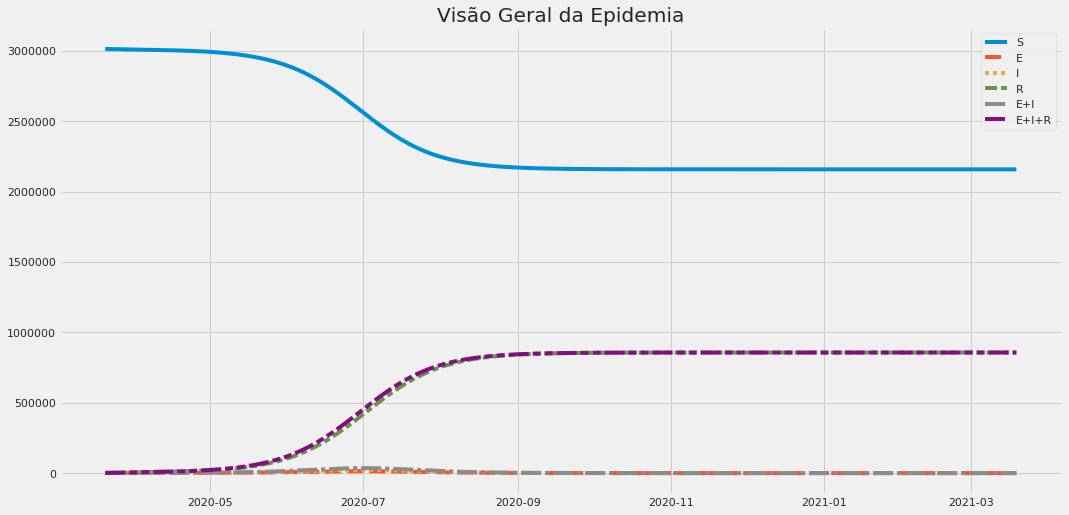

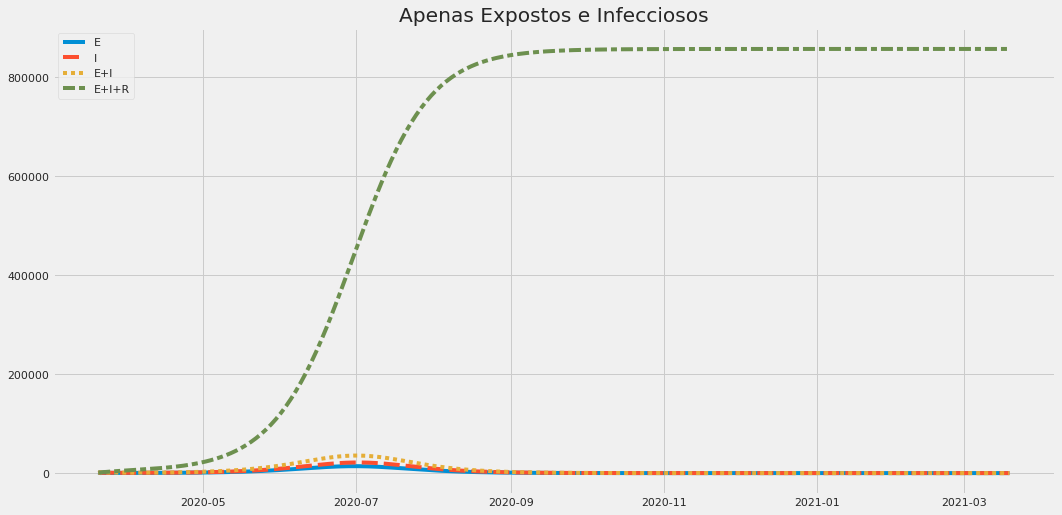

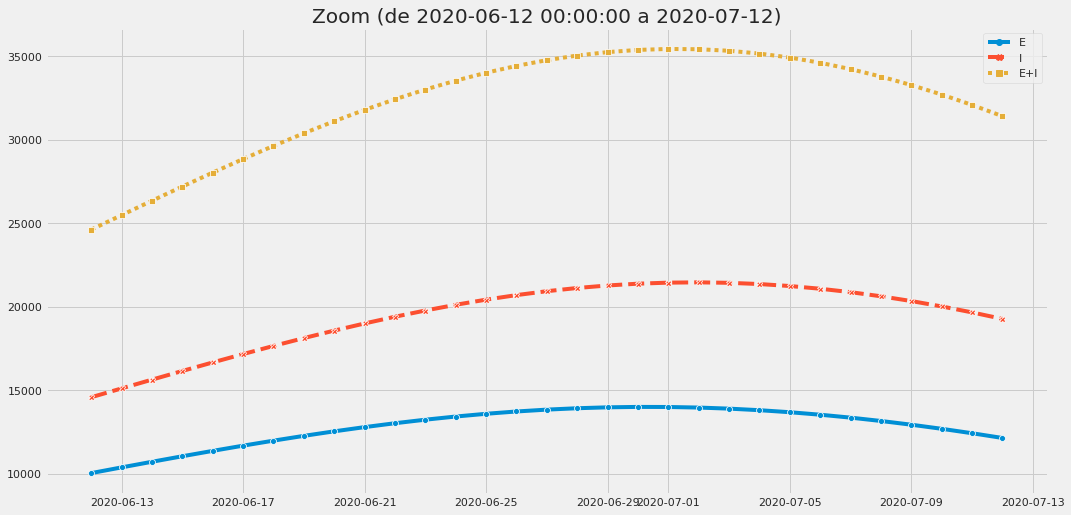

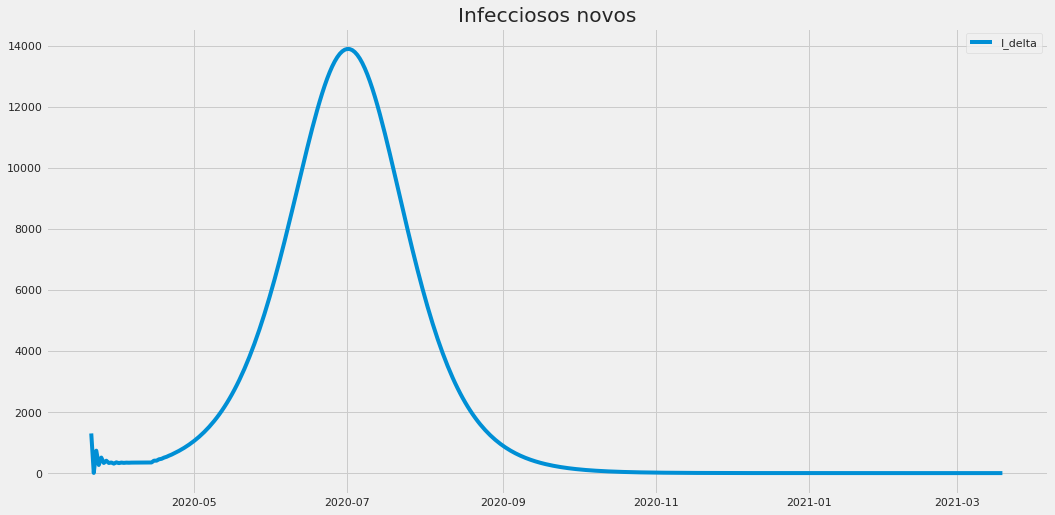

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.1750712703476232

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

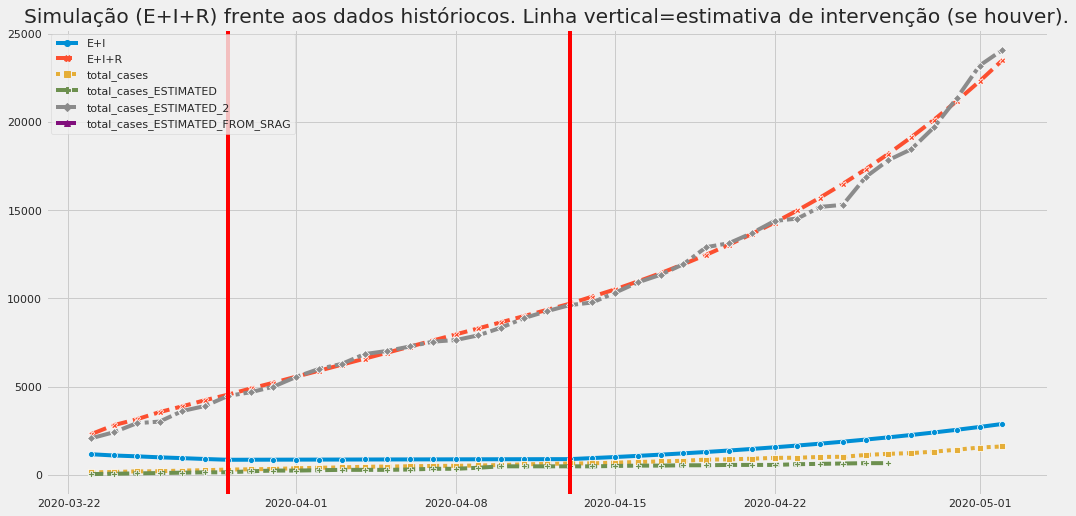

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

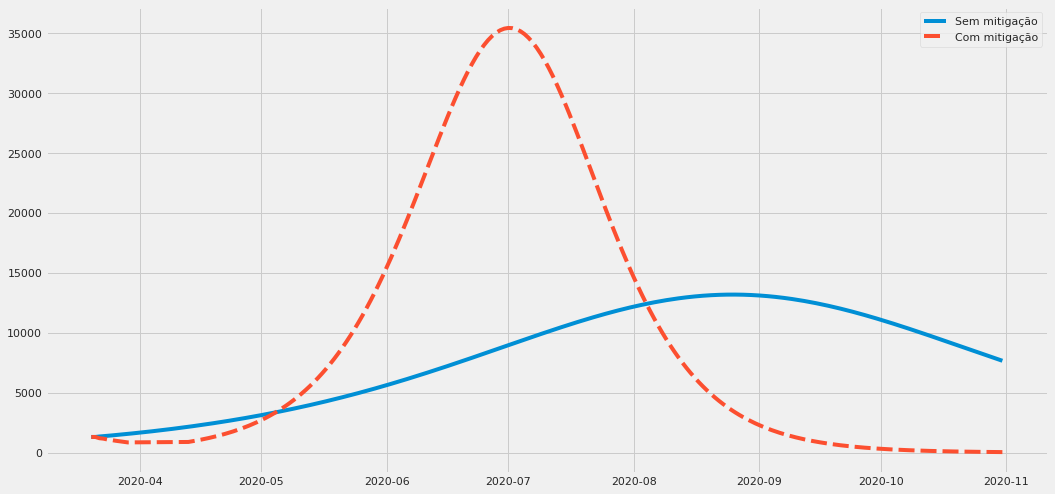

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

46

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.